In [1]:
!pip install torchsde

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import numpy as np
import torch
import torch.optim.swa_utils as swa_utils
import torchsde
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size), LipSwish()]
        
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(LipSwish())
        
        model.append(torch.nn.Linear(mlp_size, out_size))
       
        if tanh:
            model.append(torch.nn.Tanh())
            
        model.append(torch.nn.Linear(out_size, out_size))
       
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

In [5]:
class SDEFunc(torch.nn.Module):
    sde_type = 'ito'
    noise_type = 'general'

    def __init__(self, hidden_size, mlp_size, num_layers, mu, sigma, r):
        super().__init__()

        self.mu, self.sigma, self.r = mu, sigma, r

        self.hidden_size = hidden_size

        self.f_theta = MLP(hidden_size, 1, mlp_size, num_layers, tanh=True)

    def f_and_g(self, t, y):
        # t has shape ()
        # y has shape (batch_size, hidden_size) --- this is the augmented(input) variable (log_s, z)

        t = t.expand(y.size(0), 1)

        x = y[:,0].unsqueeze(1) # log(S)
        
        # f_tx = 1e-8*self.f_theta(x)
        f_tx = self.f_theta(x)
        
        drift = (self.mu*f_tx + self.r*(1. - f_tx) - 0.5*(self.sigma**2)*(f_tx**2) )

        diffusion = self.sigma*f_tx.unsqueeze(1)

        return drift, diffusion

In [6]:
class SDE(torch.nn.Module):
    def __init__(self, hidden_size, mlp_size, num_layers, mu, sigma, r, dt):
        super().__init__()
        self._func = SDEFunc(hidden_size, mlp_size, num_layers, mu, sigma, r)
        self.dt = dt

    def forward(self, x0, ts):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.
        # y0 = 1e-8*x0
        y0 = x0
    
        ys = torchsde.sdeint(self._func, y0, ts, method='euler', dt=self.dt, adaptive=False) 
    
        # normalize the data
        # y0_flat = ys[0].view(-1)
        # ys = (ys - y0_flat.mean()) / y0_flat.std()

        return ys.permute(1,0,2)

In [7]:
def results_plot(model, x0_batch, losses, controls, T, batch_size, len, v_list, a_list, times, t_size_test):

    ts_ = torch.linspace(0, T, len, device=device)
    t = ts_.repeat(batch_size, 1).unsqueeze(2)

    with torch.no_grad():

        generated_samples = model(x0_batch, ts_)
        
        x = generated_samples
        s = torch.exp(x).cpu().numpy()      
        alpha = torch.mean(torch.tensor(model._func.f_theta(x).cpu().numpy())).repeat(t_size_test, 1)
        # alpha = model._func.f_theta(x).cpu().numpy()

        fig, ax = plt.subplots(1,4,figsize=(24,4))
        for k in range(batch_size):
            ax[0].plot(s[k,:], alpha=0.1, c='red')
            ax[0].set_title('Process $S_t$')
            ax[1].plot(alpha, alpha=0.1, c='blue')
            # ax[1].plot(alpha[k,:], alpha=0.1, c='blue')
            ax[1].set_title('Control $A_t$')
        ax[2].plot(torch.tensor(losses).cpu().numpy())
        ax[2].plot(v_list, 'r--')
        ax[2].set_title(f'v(t=0, x={s0})')
        ax[3].plot(torch.tensor(controls).cpu().numpy())
        ax[3].plot(a_list, 'r--')
        ax[3].set_title(f'control(t=0, x={s0})')
        plt.show()

In [8]:
# Architectural hyperparameters. 
hidden_size = 1
mlp_size = 1
num_layers = 2

# rescaling constants
scale_lift = 1e-8
scale_vec_fields = 1e-8
scale_readout_weight = 1e-8
scale_readout_bias = 1e0

# parameters of dynamics
mu = 0.5
sigma = 0.1
r = 1. #0
p = 0.005
T = 0.1
dt = 0.001

# Training hyperparameters. 
lr = 1e-1             
weight_decay = 1e-2
batch_size = 500        
t_size = 2
t_size_test = 100
iterations = 10000  
iterations_per_print = 100
times = int(iterations/iterations_per_print)

In [9]:
model = SDE(hidden_size, mlp_size, num_layers, mu, sigma, r, dt).to(device)

In [10]:
model

SDE(
  (_func): SDEFunc(
    (f_theta): MLP(
      (_model): Sequential(
        (0): Linear(in_features=1, out_features=1, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=1, out_features=1, bias=True)
        (5): Tanh()
        (6): Linear(in_features=1, out_features=1, bias=True)
      )
    )
  )
)

In [11]:
# # Picking a good initialisation is important!
# with torch.no_grad():
#     for param in model._func.f_theta.parameters():
#         param *= scale_vec_fields
#     for param in model.g_theta.parameters():
#         param *= scale_lift
#     for param in model._func.A_theta.weight:
#         param *= scale_readout_weight
#     for param in model._func.A_theta.bias:
#         param *= scale_readout_bias
#         # param += 10


optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# optimiser = torch.optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=.999)
ts = torch.linspace(0, T, t_size, device=device)
losses = []
controls = []

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.07 
 theoretical constant optimal control: -50.25


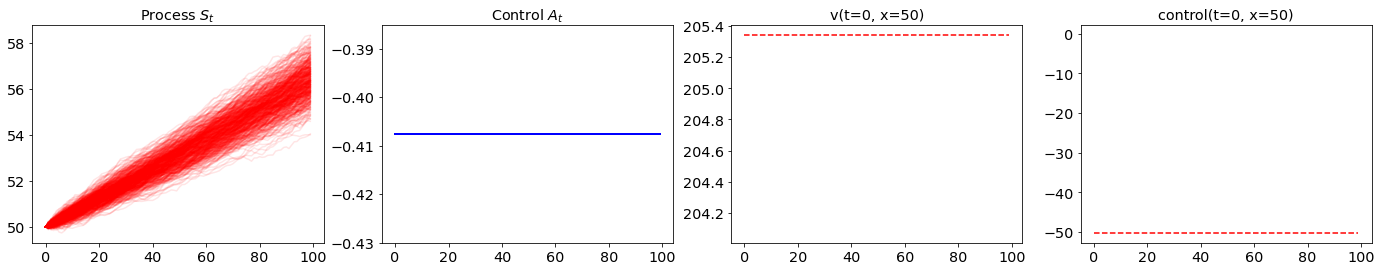

  1%|▍                                      | 100/10000 [00:07<09:40, 17.05it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


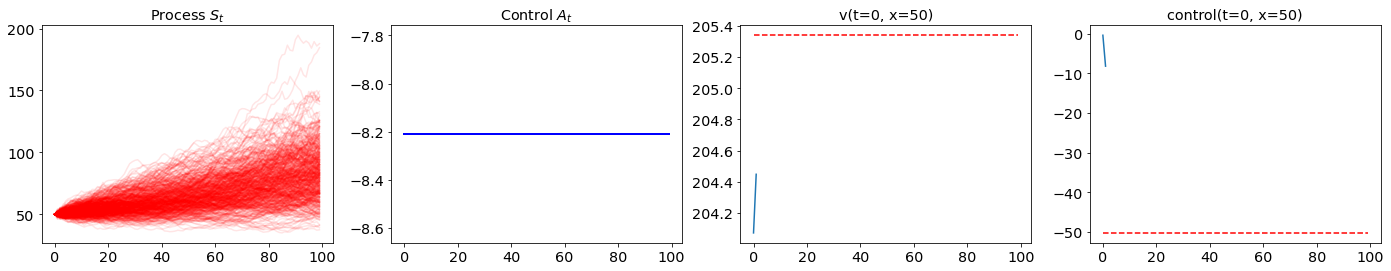

  2%|▊                                      | 200/10000 [00:14<09:40, 16.89it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


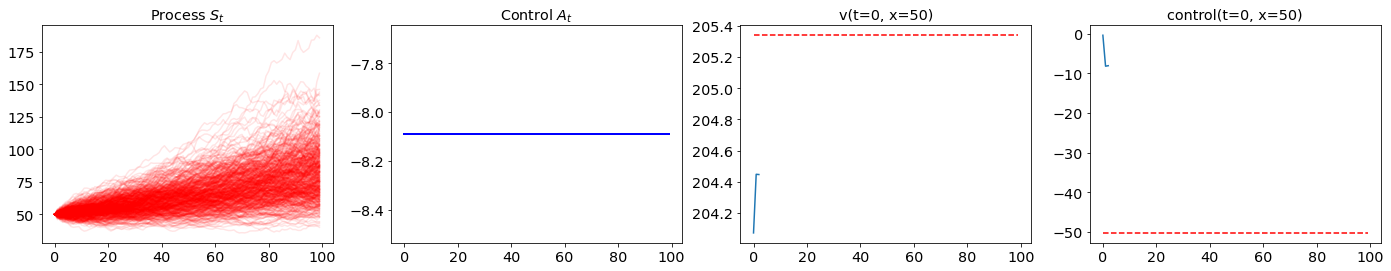

  3%|█▏                                     | 300/10000 [00:21<09:33, 16.92it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


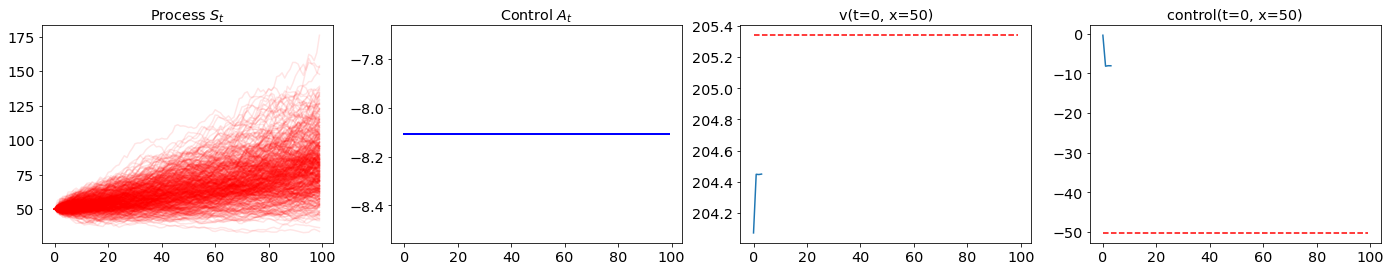

  4%|█▌                                     | 400/10000 [00:28<09:40, 16.54it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


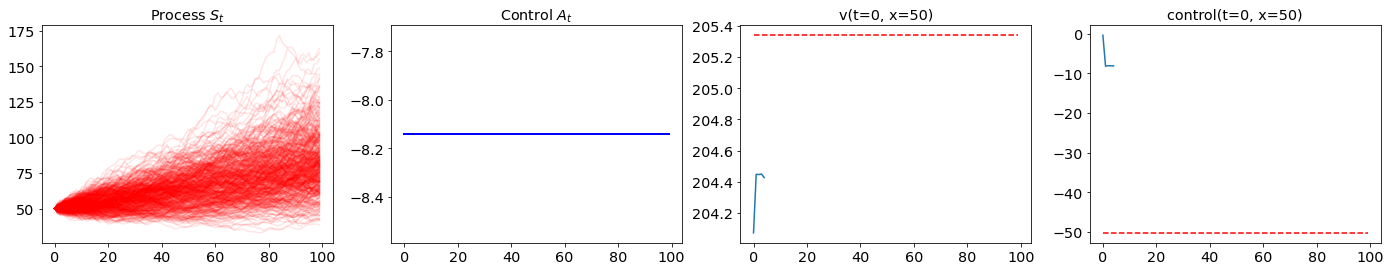

  5%|█▉                                     | 500/10000 [00:35<09:40, 16.37it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


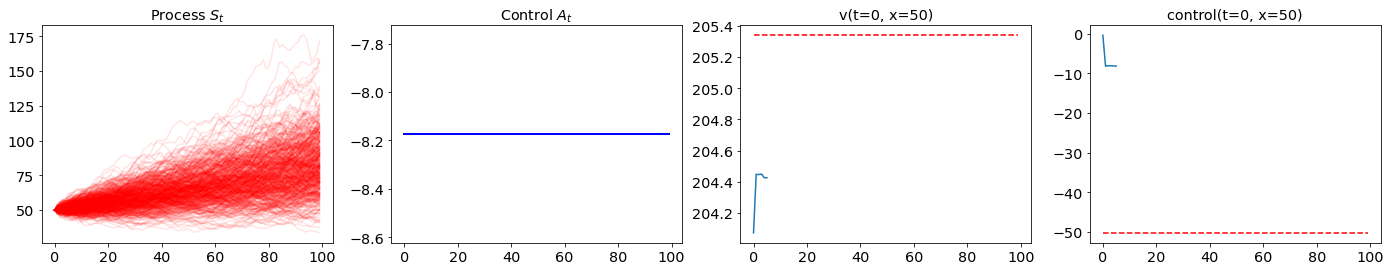

  6%|██▎                                    | 600/10000 [00:42<09:17, 16.86it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


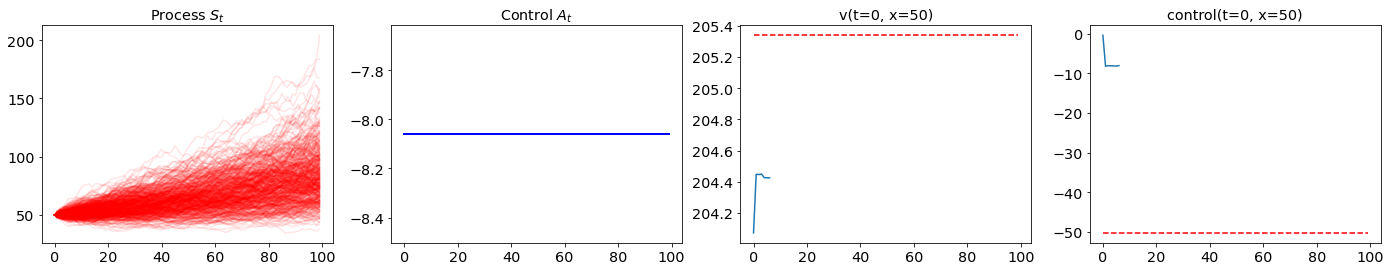

  7%|██▋                                    | 700/10000 [00:49<09:10, 16.91it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


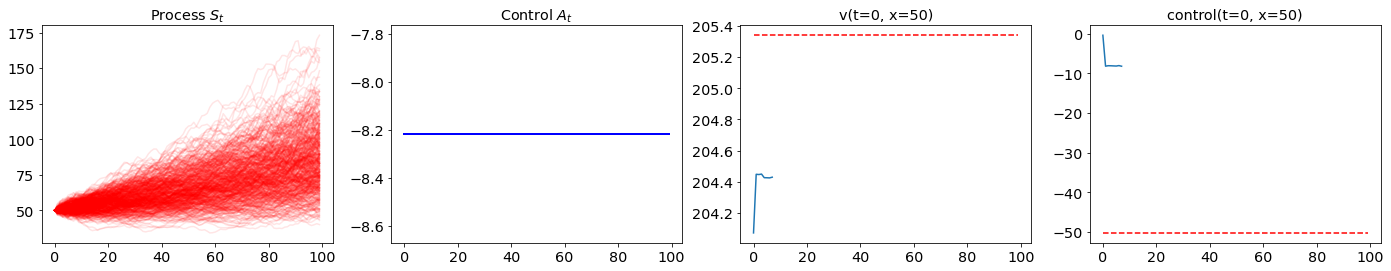

  8%|███                                    | 800/10000 [00:56<09:12, 16.65it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


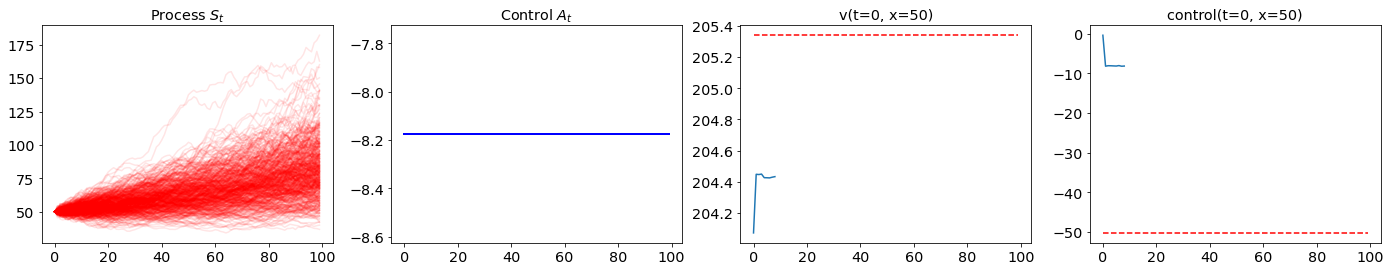

  9%|███▌                                   | 900/10000 [01:03<09:22, 16.18it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


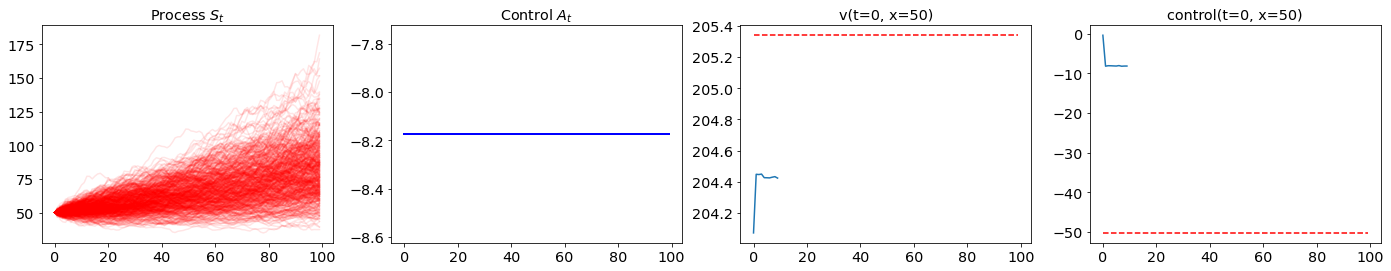

 10%|███▊                                  | 1000/10000 [01:10<08:45, 17.14it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


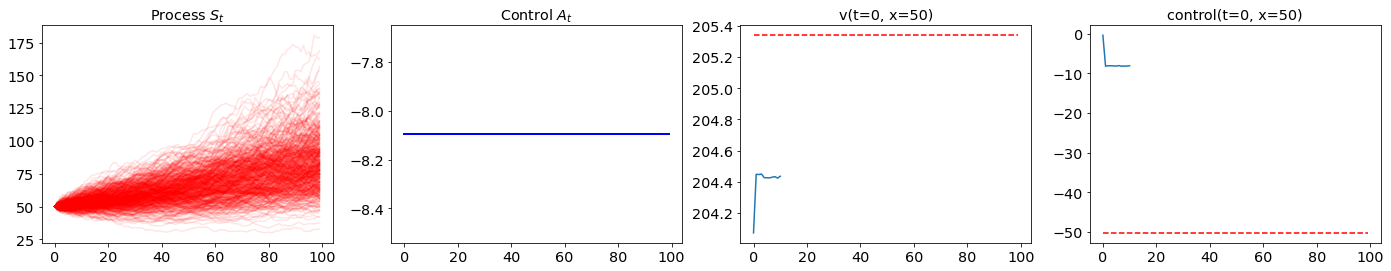

 11%|████▏                                 | 1100/10000 [01:17<08:42, 17.03it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


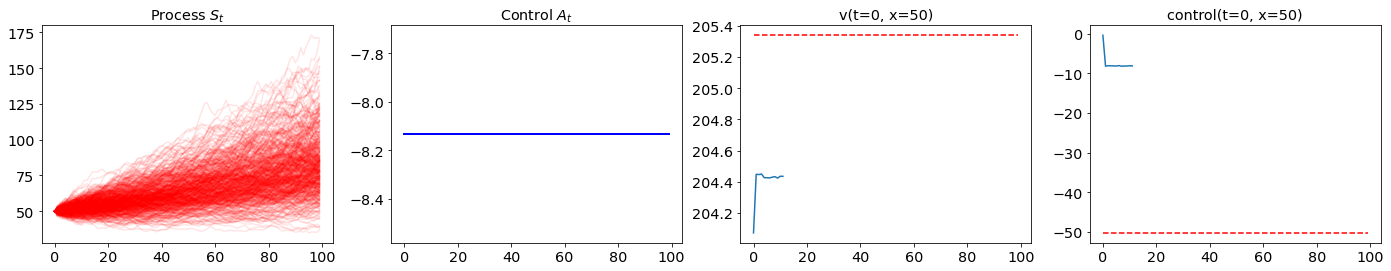

 12%|████▌                                 | 1200/10000 [01:24<08:21, 17.54it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


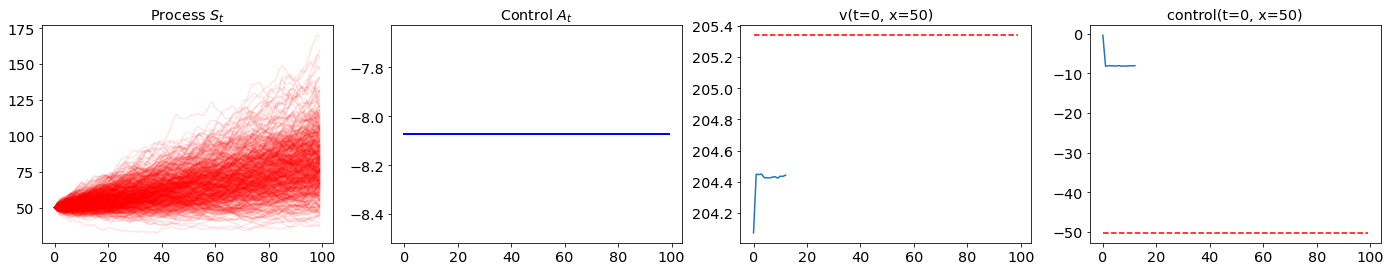

 13%|████▉                                 | 1300/10000 [01:31<08:09, 17.79it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


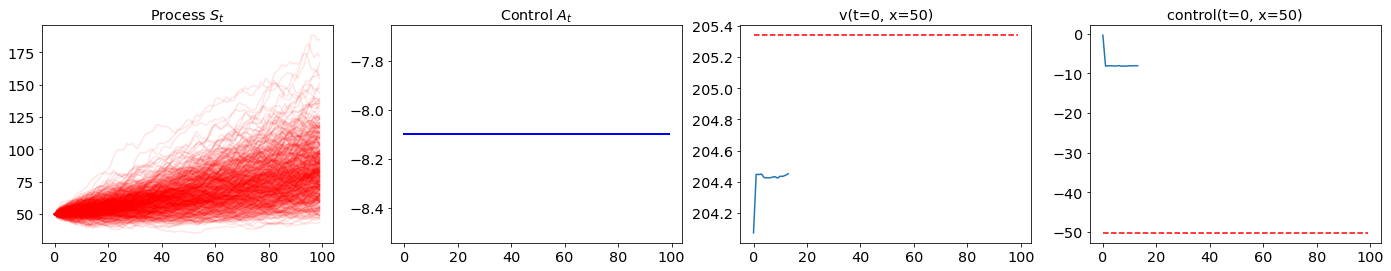

 14%|█████▎                                | 1400/10000 [01:37<08:05, 17.70it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


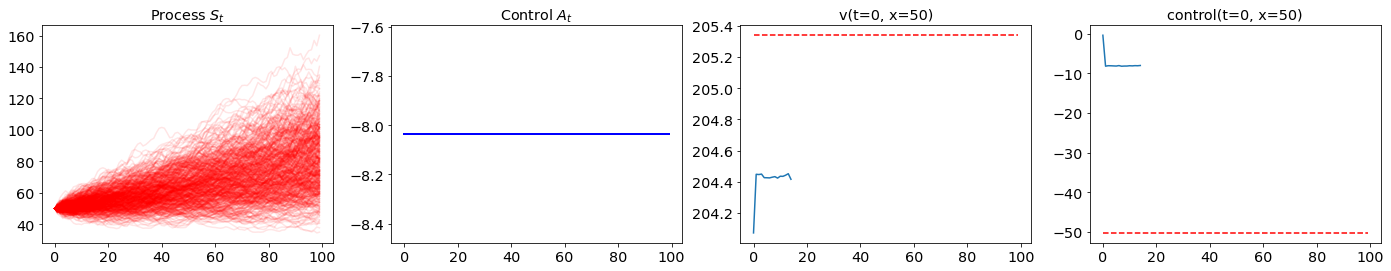

 15%|█████▋                                | 1500/10000 [01:44<08:02, 17.62it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


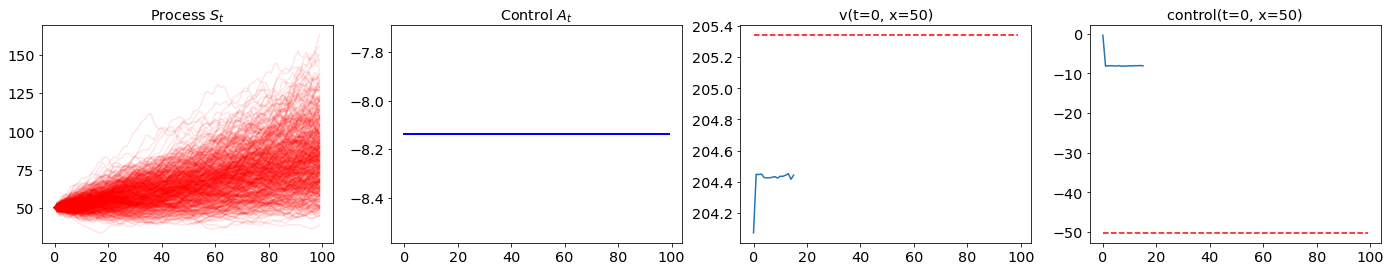

 16%|██████                                | 1600/10000 [01:51<07:53, 17.72it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


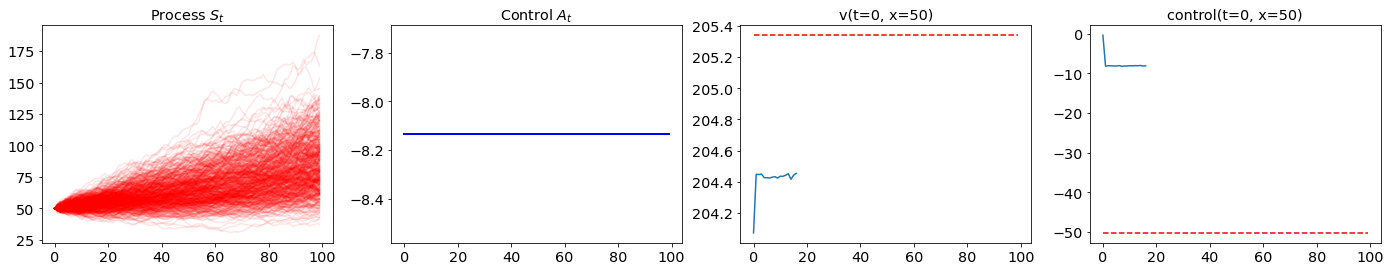

 17%|██████▍                               | 1700/10000 [01:57<07:48, 17.71it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


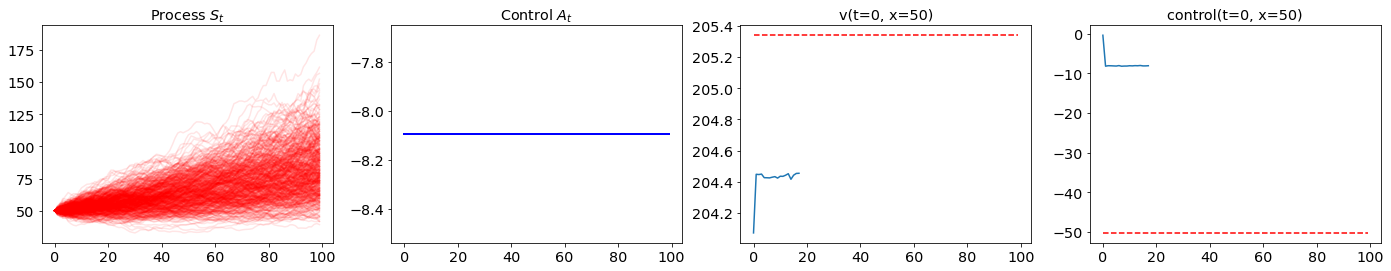

 18%|██████▊                               | 1800/10000 [02:04<07:45, 17.63it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


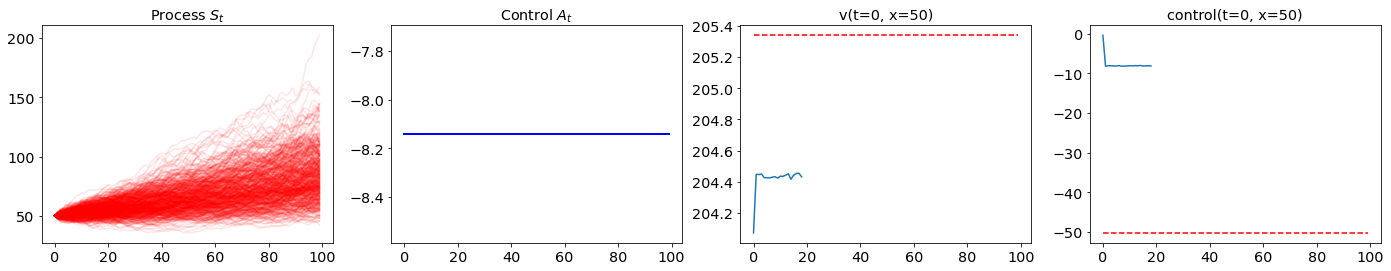

 19%|███████▏                              | 1900/10000 [02:11<07:44, 17.43it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.41 
 theoretical constant optimal control: -50.25


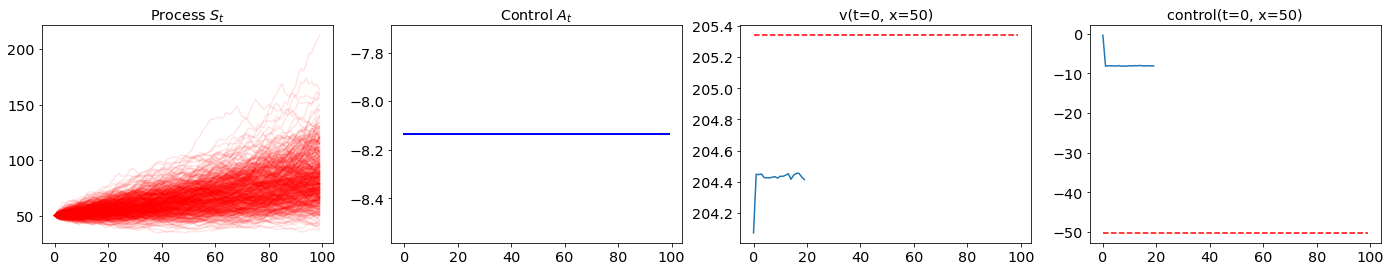

 20%|███████▌                              | 2000/10000 [02:18<07:40, 17.37it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


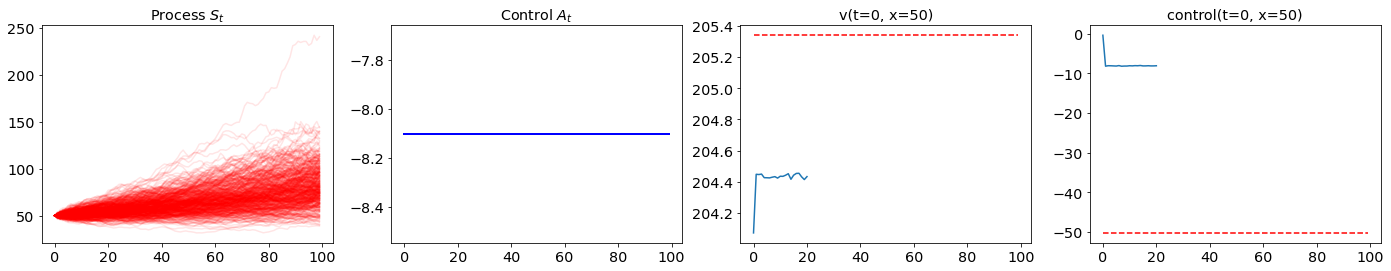

 21%|███████▉                              | 2100/10000 [02:24<07:33, 17.42it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


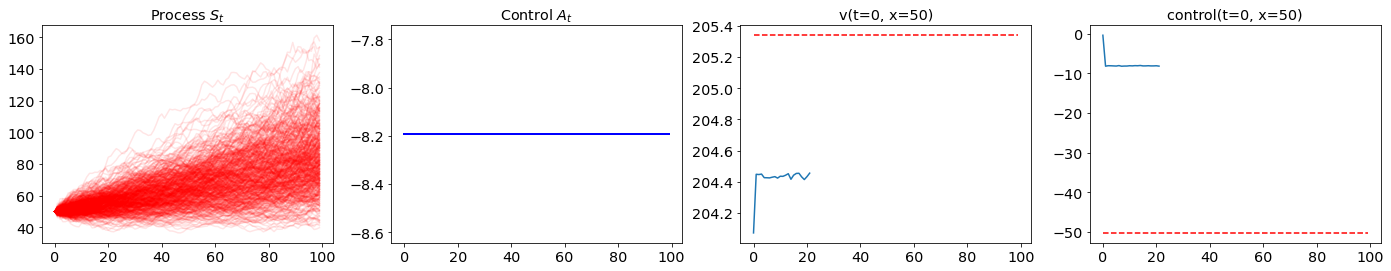

 22%|████████▎                             | 2200/10000 [02:31<07:21, 17.66it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


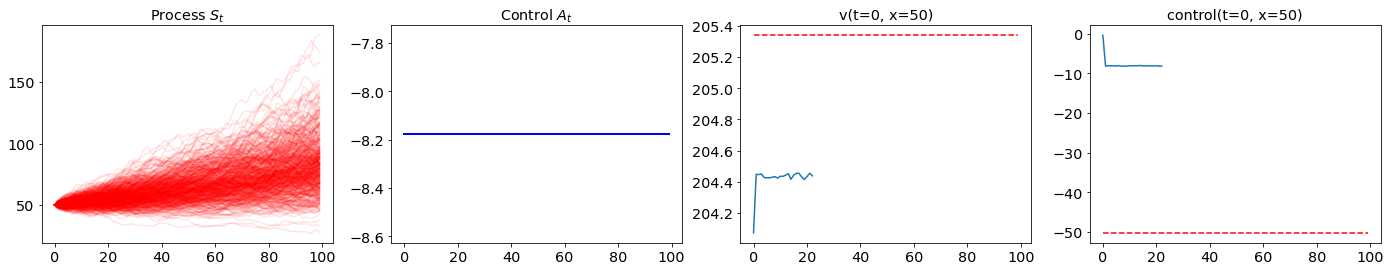

 23%|████████▋                             | 2300/10000 [02:38<07:15, 17.69it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


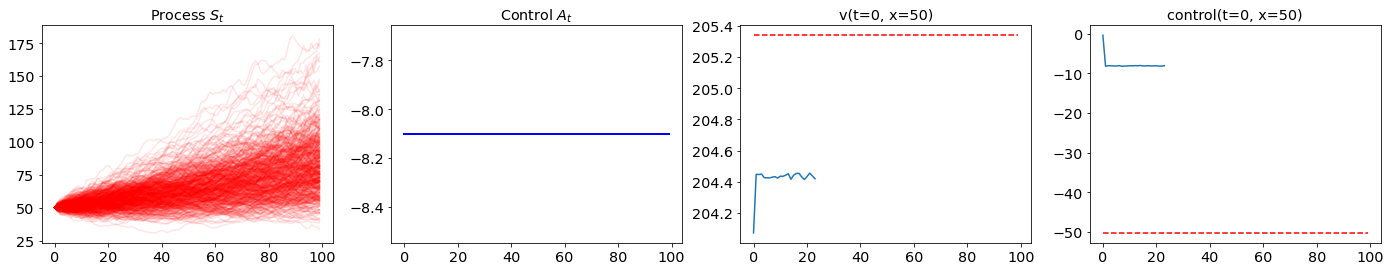

 24%|█████████                             | 2400/10000 [02:44<07:11, 17.60it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


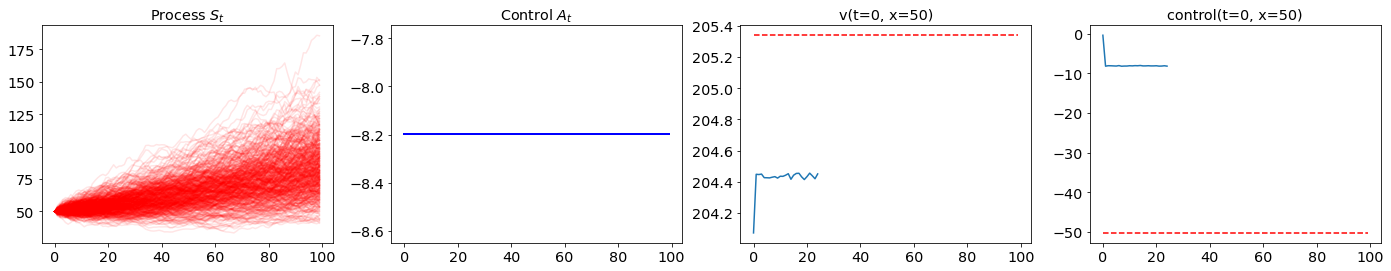

 25%|█████████▌                            | 2500/10000 [02:51<07:08, 17.50it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


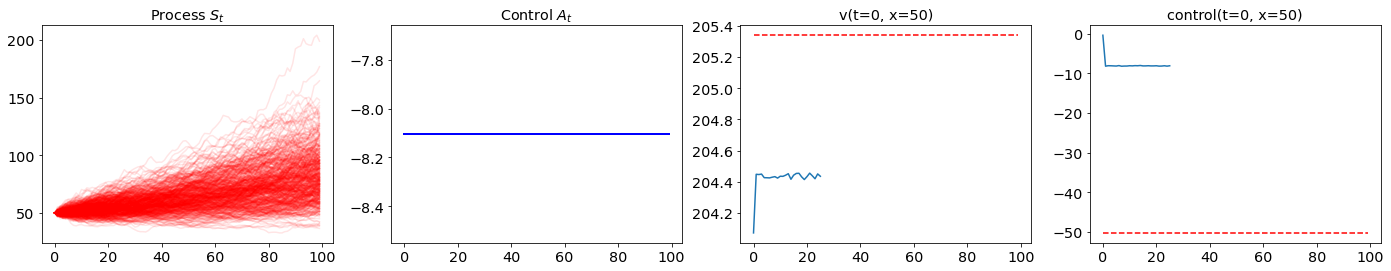

 26%|█████████▉                            | 2600/10000 [02:58<06:58, 17.67it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


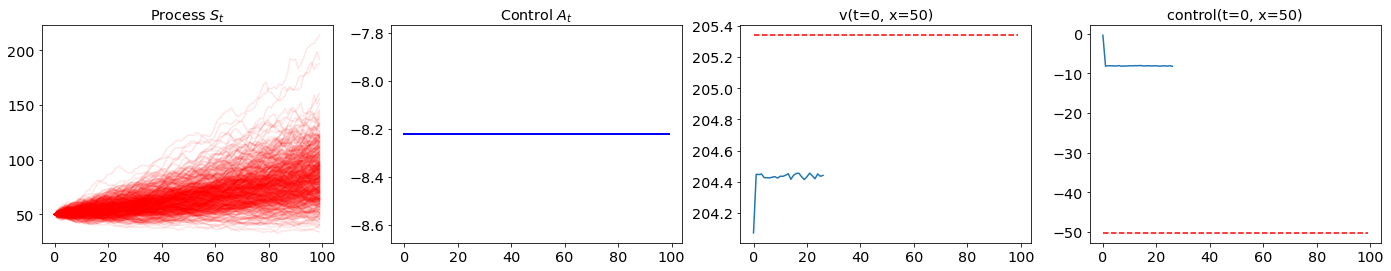

 27%|██████████▎                           | 2700/10000 [03:04<06:52, 17.71it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


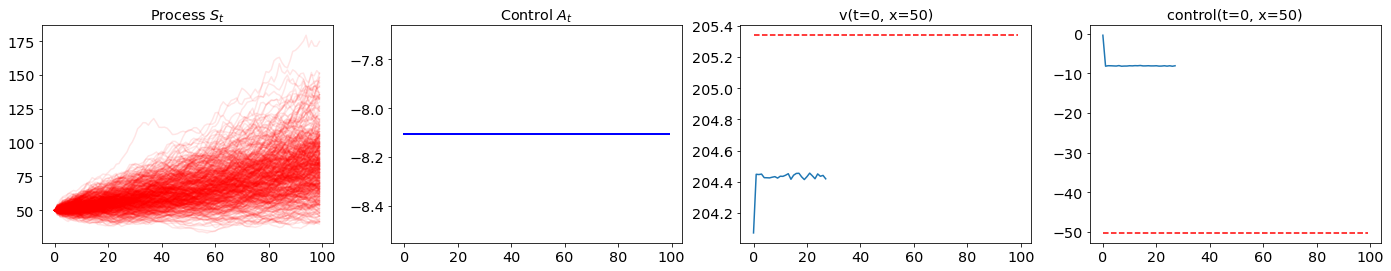

 28%|██████████▋                           | 2800/10000 [03:11<06:47, 17.68it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


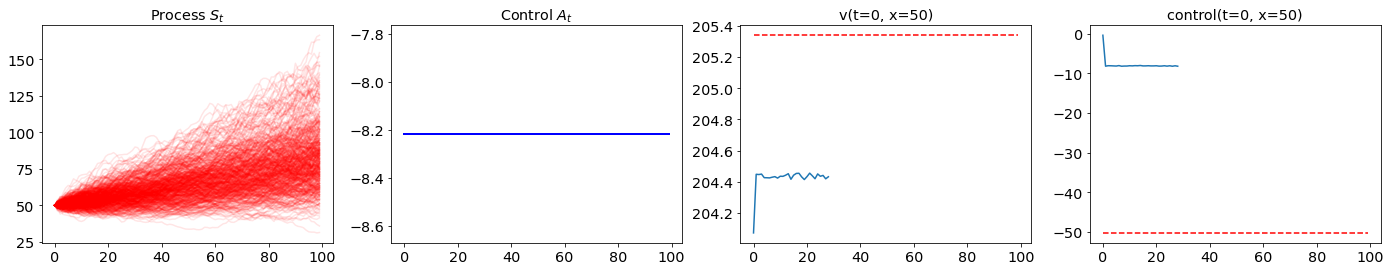

 29%|███████████                           | 2900/10000 [03:18<06:43, 17.61it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


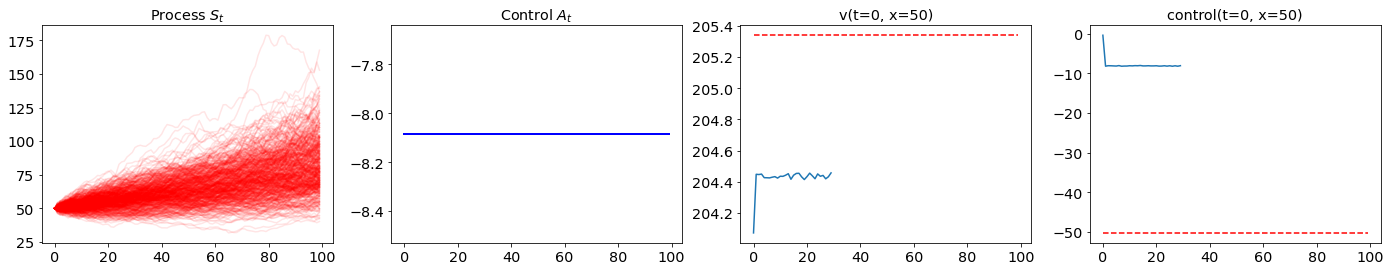

 30%|███████████▍                          | 3000/10000 [03:25<06:32, 17.85it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


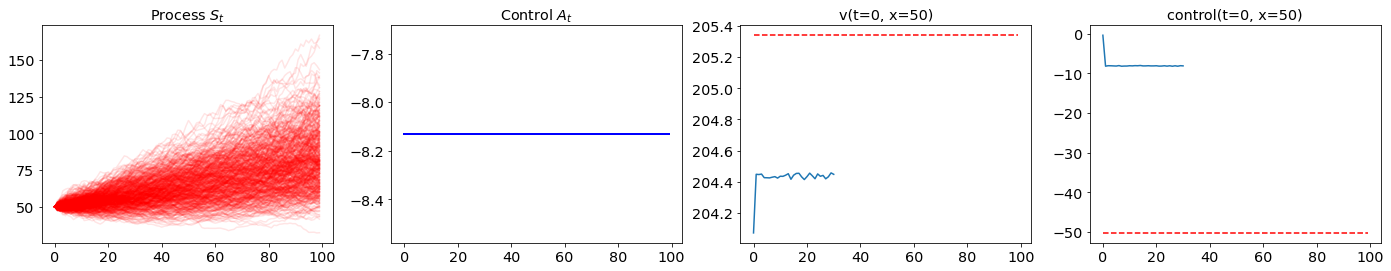

 31%|███████████▊                          | 3100/10000 [03:31<06:31, 17.62it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


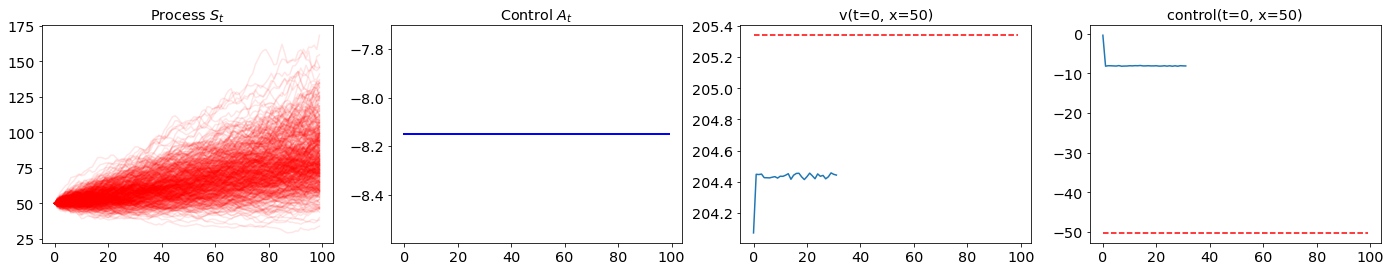

 32%|████████████▏                         | 3200/10000 [03:38<06:28, 17.48it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


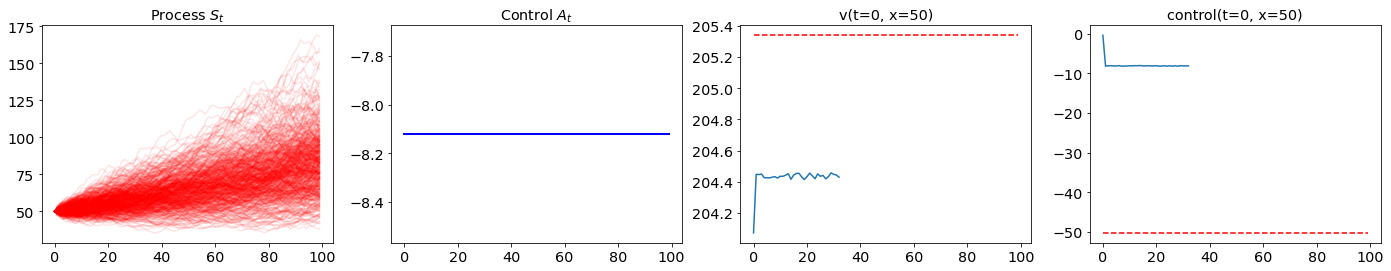

 33%|████████████▌                         | 3300/10000 [03:45<06:26, 17.35it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.39 
 theoretical constant optimal control: -50.25


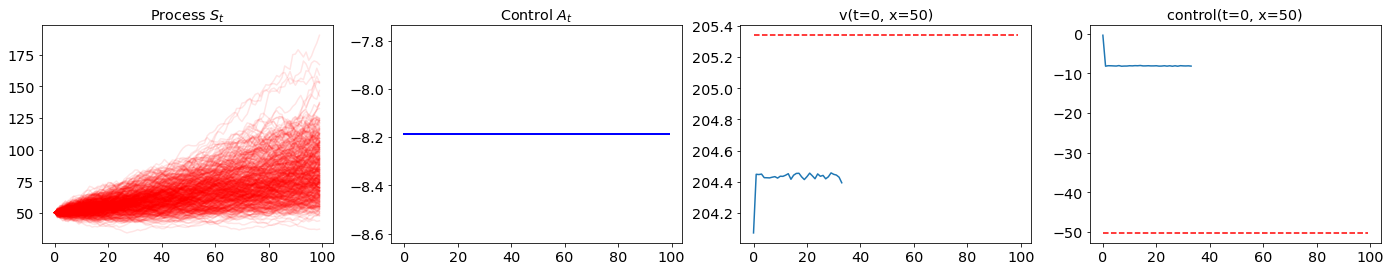

 34%|████████████▉                         | 3400/10000 [03:52<06:10, 17.79it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


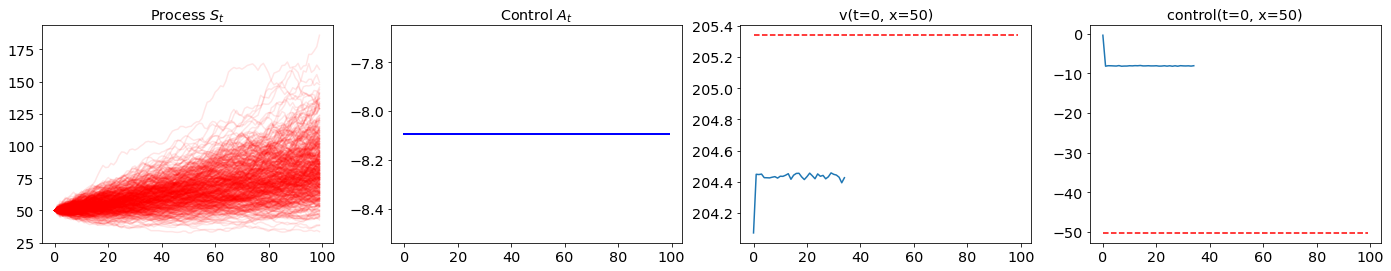

 35%|█████████████▎                        | 3500/10000 [03:58<06:13, 17.42it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


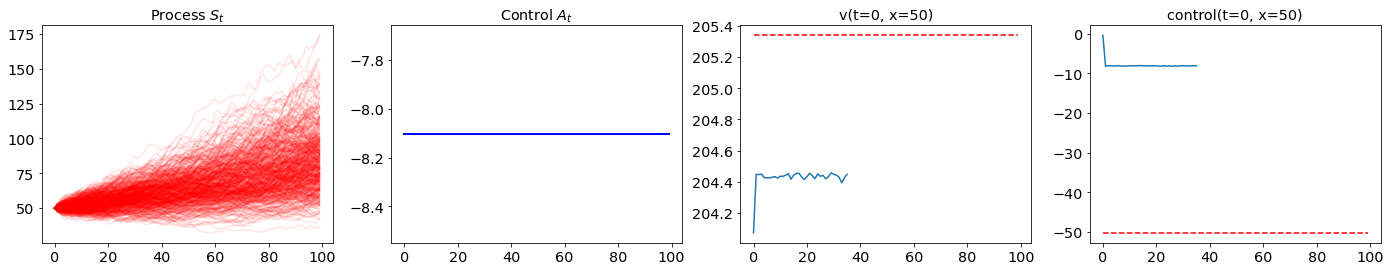

 36%|█████████████▋                        | 3600/10000 [04:05<06:00, 17.76it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


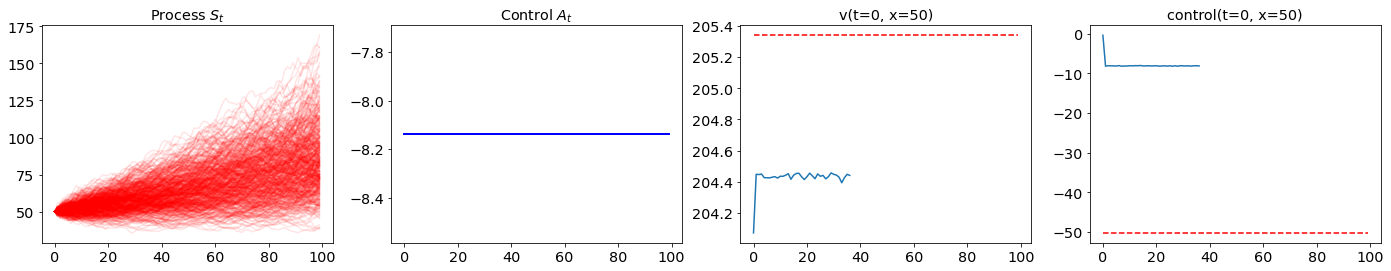

 37%|██████████████                        | 3700/10000 [04:12<05:56, 17.66it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


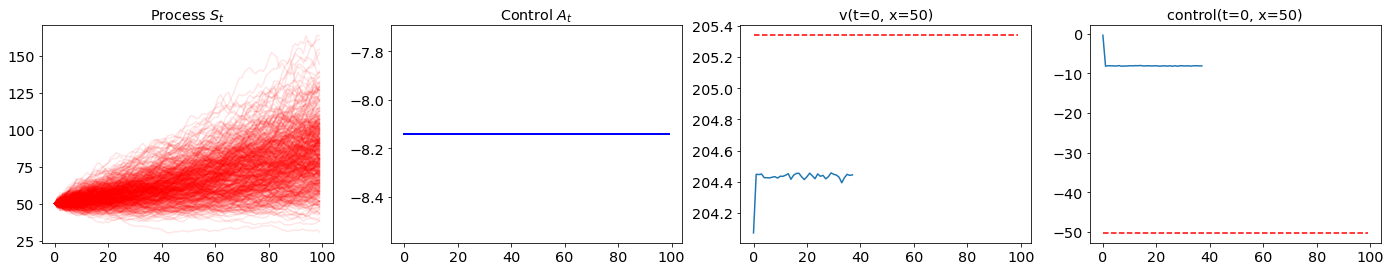

 38%|██████████████▍                       | 3800/10000 [04:18<05:58, 17.30it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


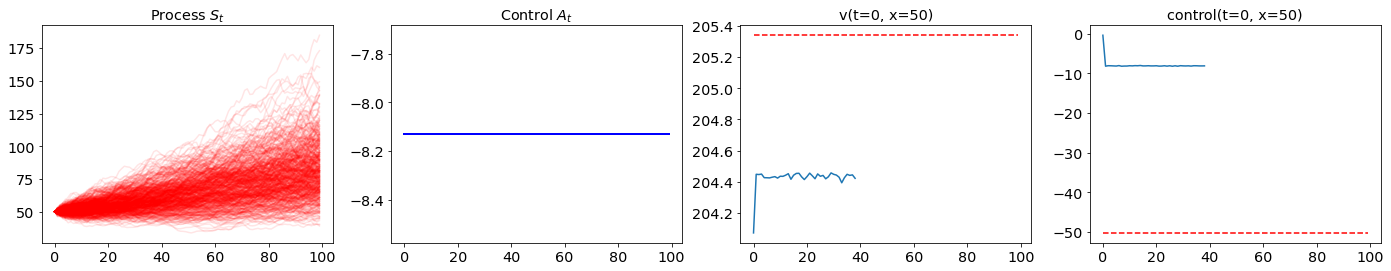

 39%|██████████████▊                       | 3900/10000 [04:25<05:59, 16.99it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


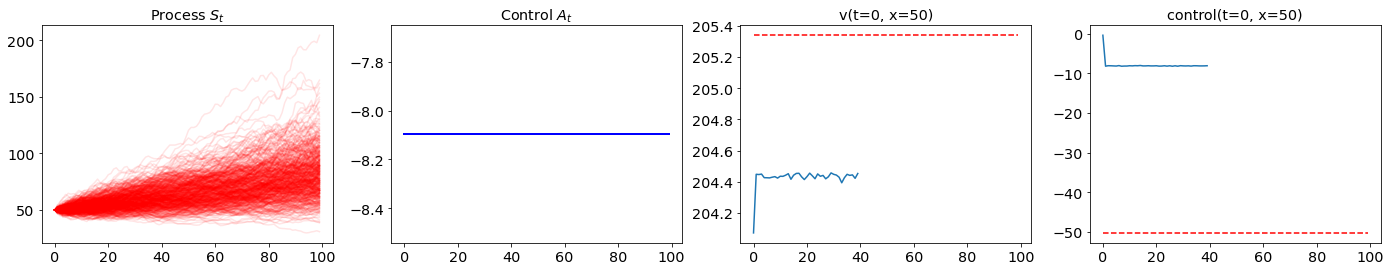

 40%|███████████████▏                      | 4000/10000 [04:32<05:44, 17.39it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


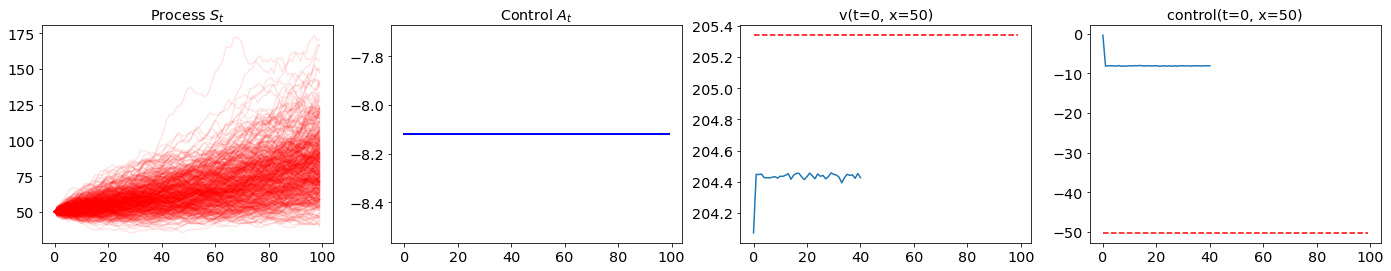

 41%|███████████████▌                      | 4100/10000 [04:38<05:36, 17.52it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


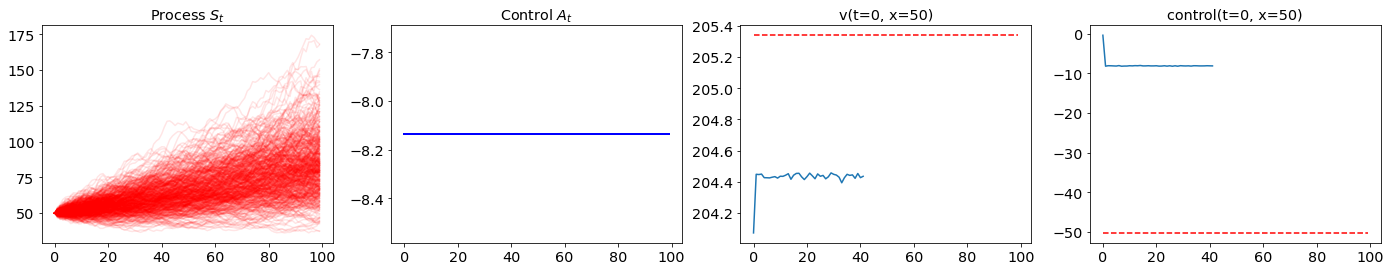

 42%|███████████████▉                      | 4200/10000 [04:45<05:29, 17.59it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


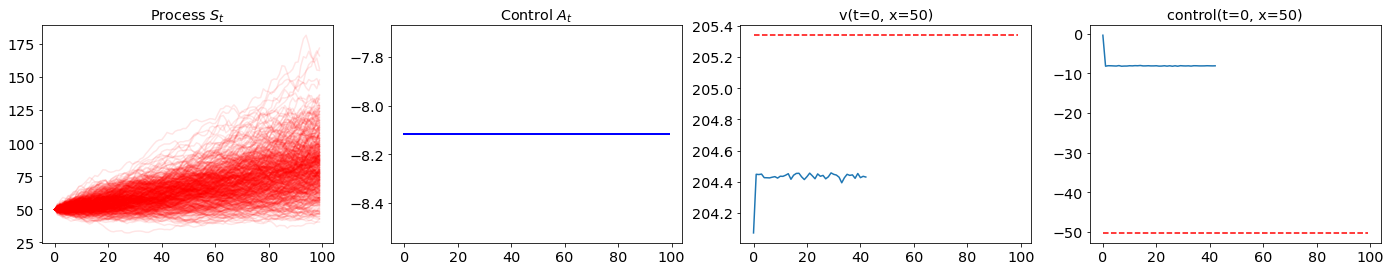

 43%|████████████████▎                     | 4300/10000 [04:52<05:23, 17.64it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


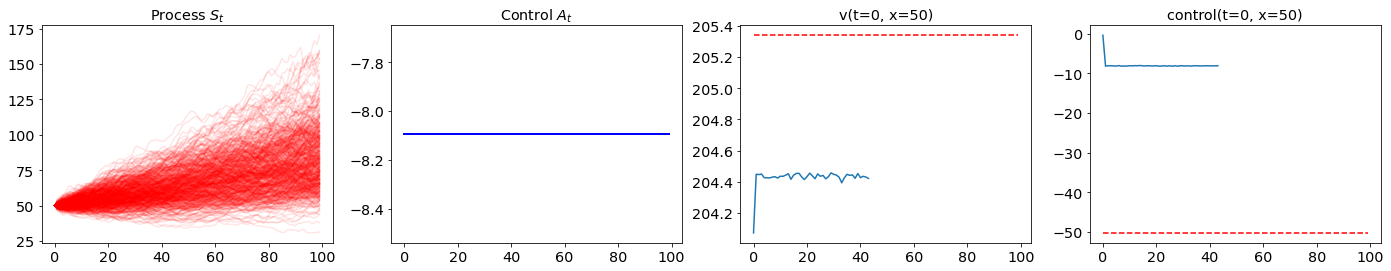

 44%|████████████████▋                     | 4400/10000 [05:00<05:19, 17.51it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


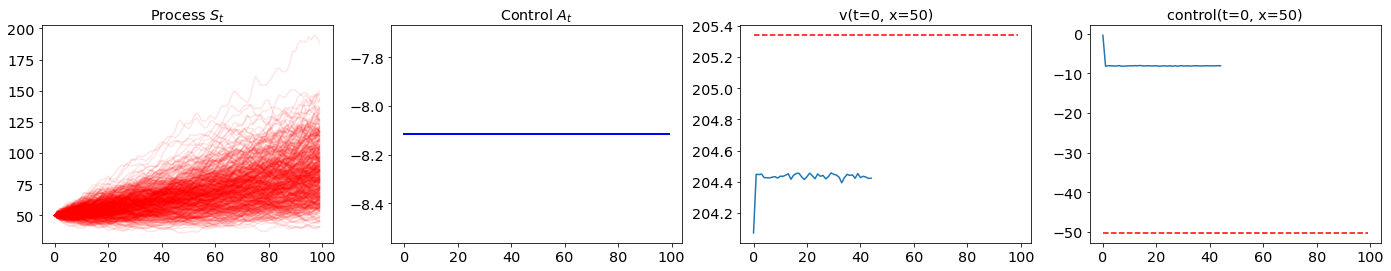

 45%|█████████████████                     | 4500/10000 [05:06<05:13, 17.53it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


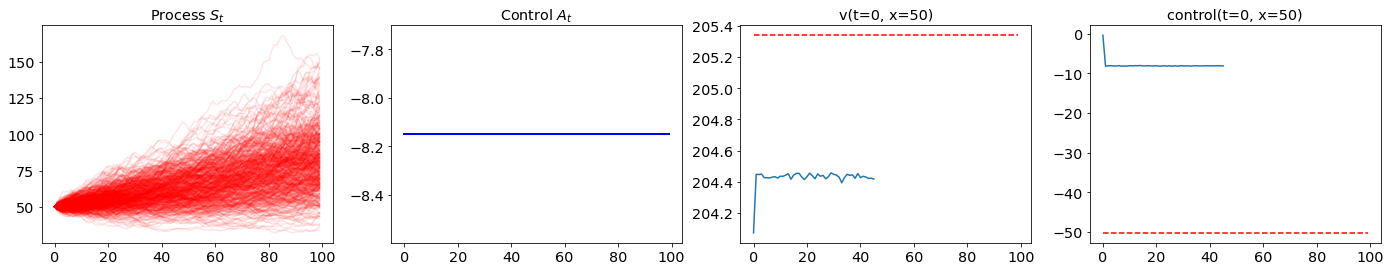

 46%|█████████████████▍                    | 4600/10000 [05:13<05:20, 16.84it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


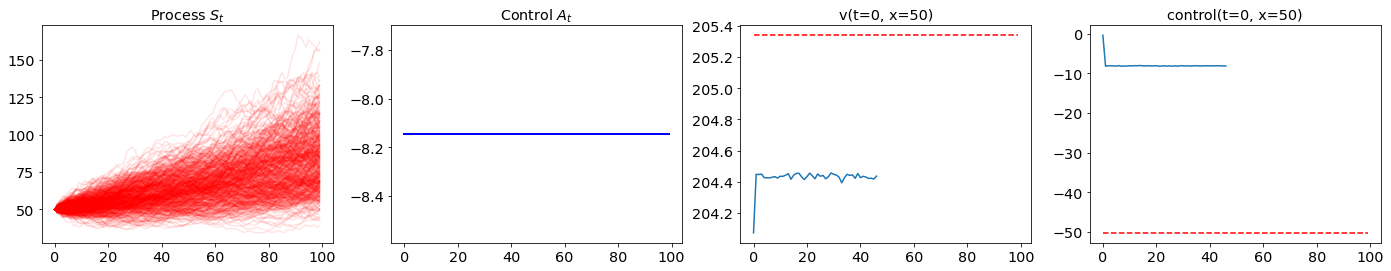

 47%|█████████████████▊                    | 4700/10000 [05:20<05:02, 17.51it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


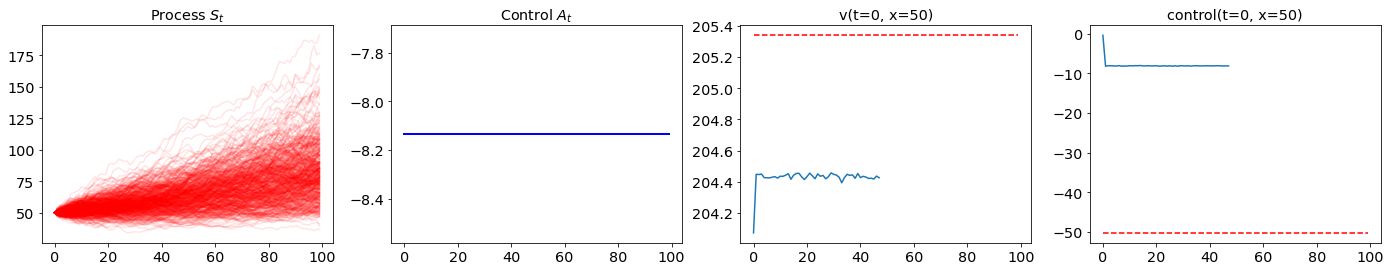

 48%|██████████████████▏                   | 4800/10000 [05:26<04:53, 17.70it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


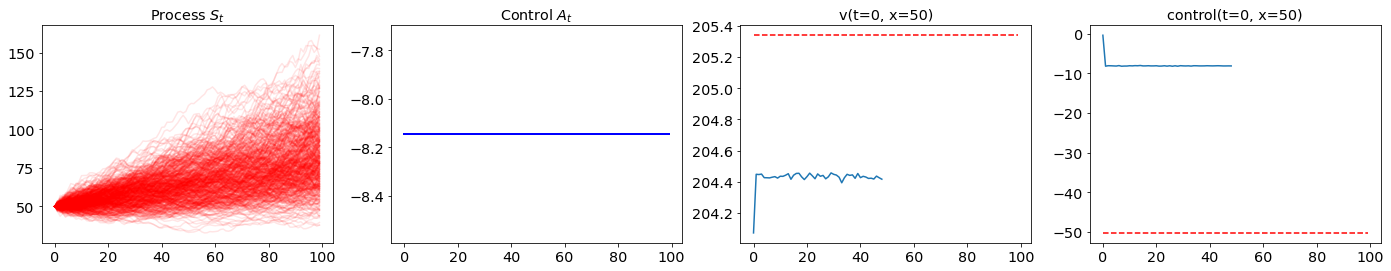

 49%|██████████████████▌                   | 4900/10000 [05:33<04:47, 17.73it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


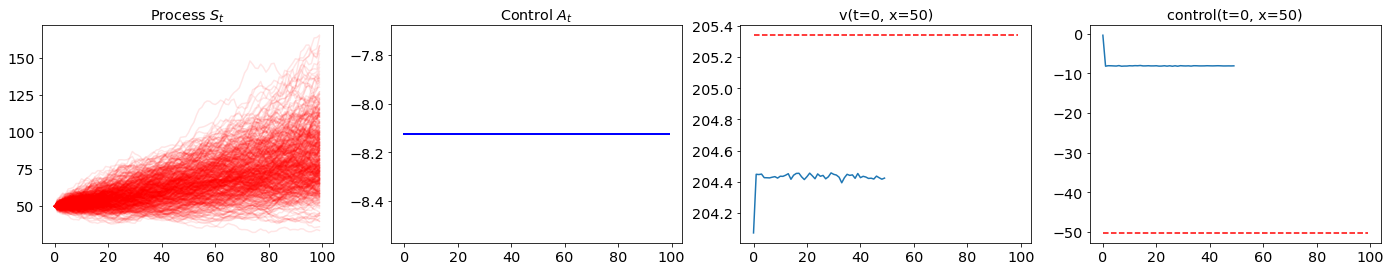

 50%|███████████████████                   | 5000/10000 [05:40<04:41, 17.73it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


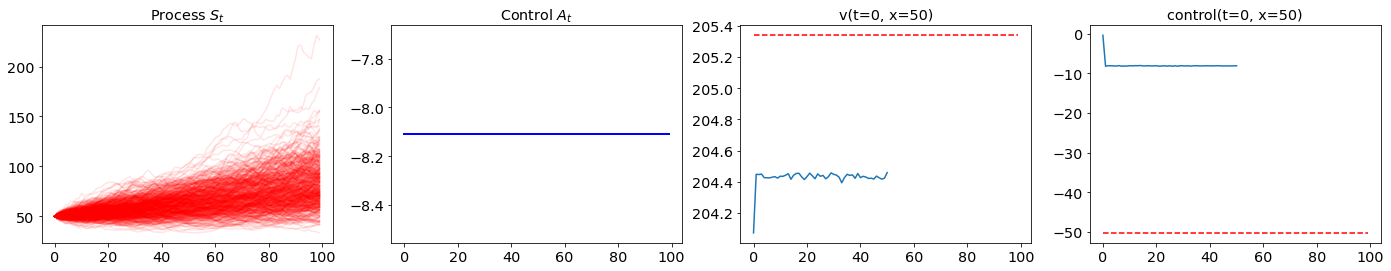

 51%|███████████████████▍                  | 5100/10000 [05:47<04:39, 17.51it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


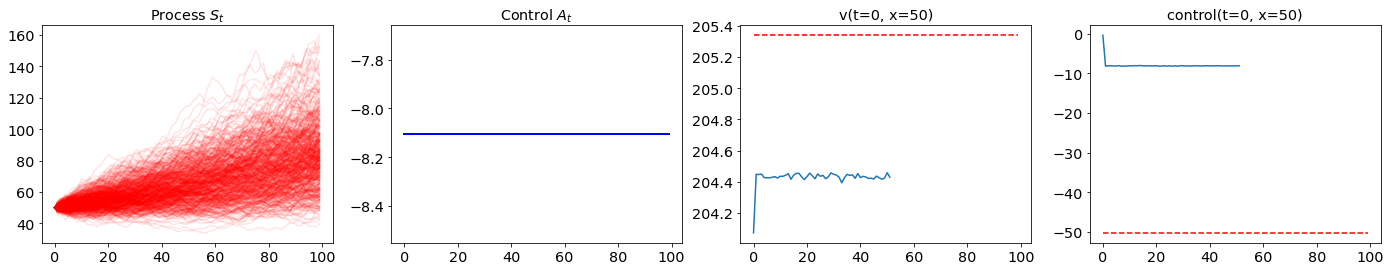

 52%|███████████████████▊                  | 5200/10000 [05:53<04:32, 17.63it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


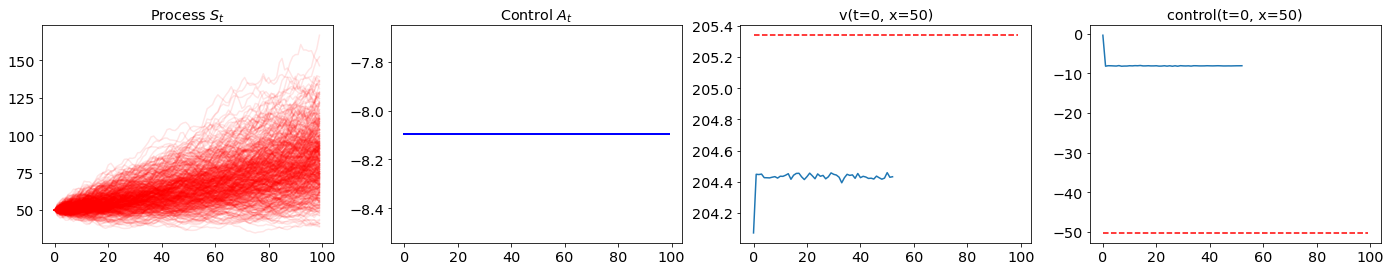

 53%|████████████████████▏                 | 5300/10000 [06:00<04:26, 17.62it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


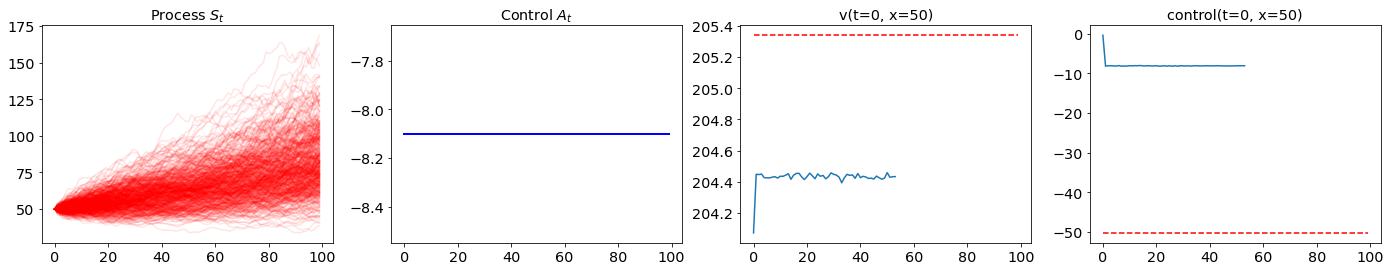

 54%|████████████████████▌                 | 5400/10000 [06:07<04:17, 17.86it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


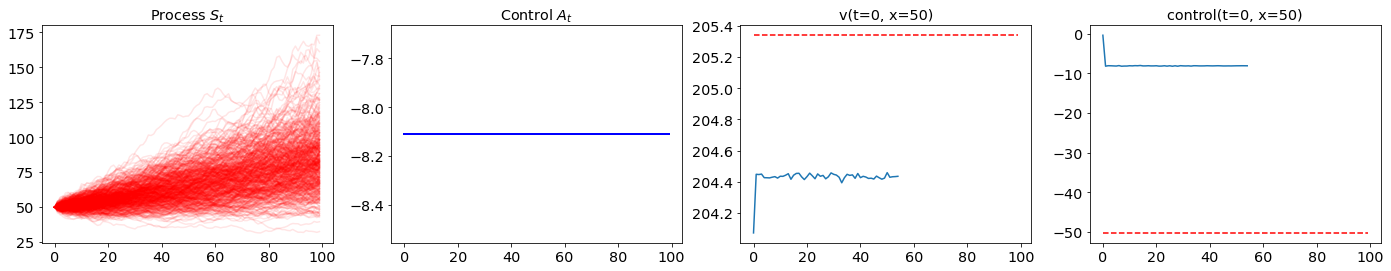

 55%|████████████████████▉                 | 5500/10000 [06:13<04:15, 17.62it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


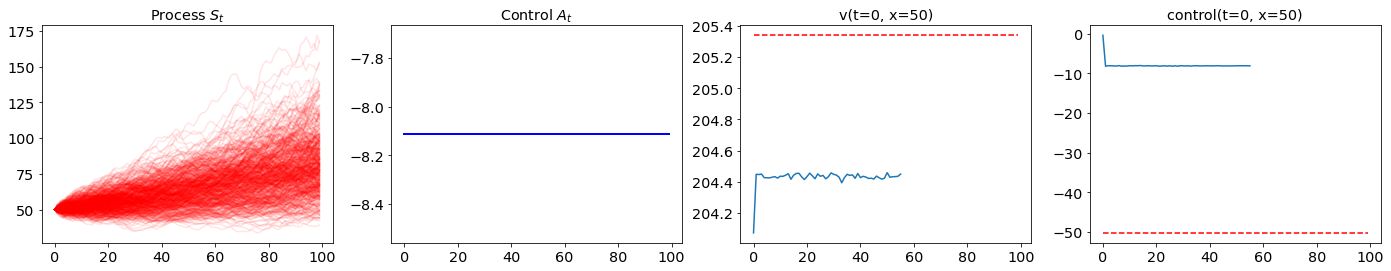

 56%|█████████████████████▎                | 5600/10000 [06:20<04:06, 17.85it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


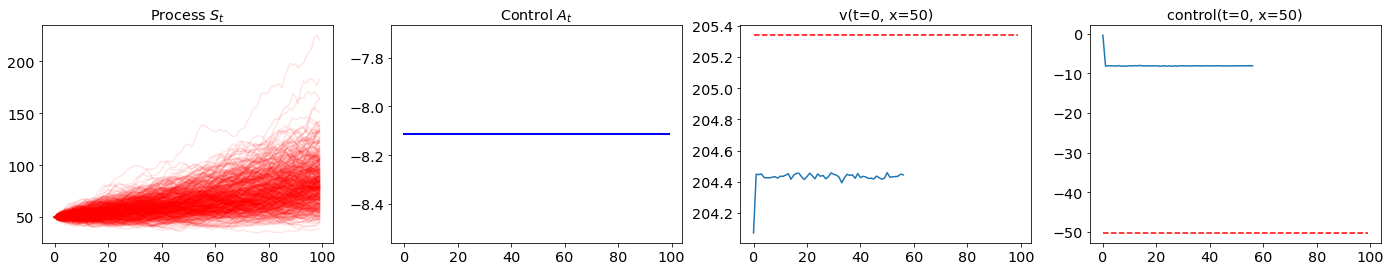

 57%|█████████████████████▋                | 5700/10000 [06:27<04:05, 17.50it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


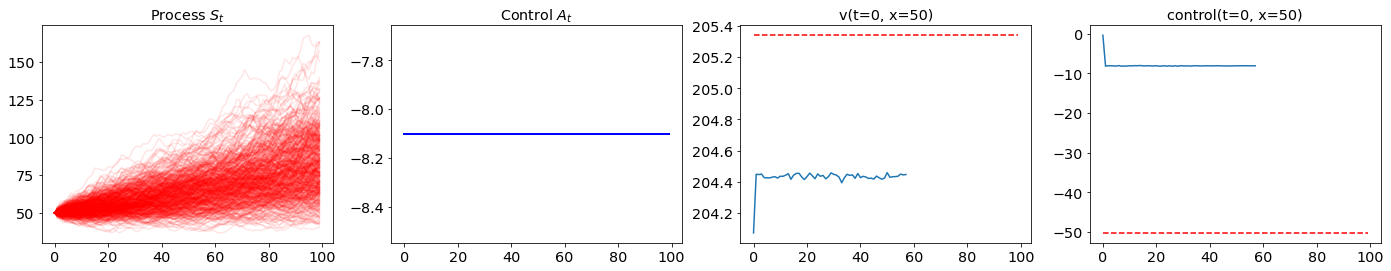

 58%|██████████████████████                | 5800/10000 [06:34<04:04, 17.20it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.47 
 theoretical constant optimal control: -50.25


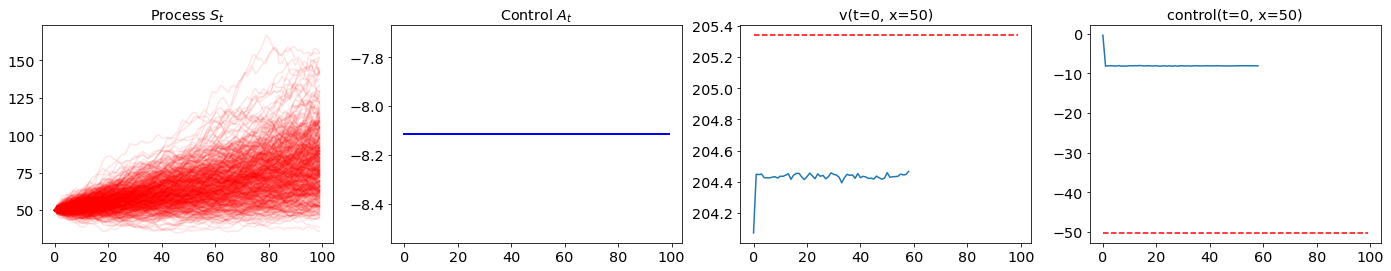

 59%|██████████████████████▍               | 5900/10000 [06:40<03:56, 17.35it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


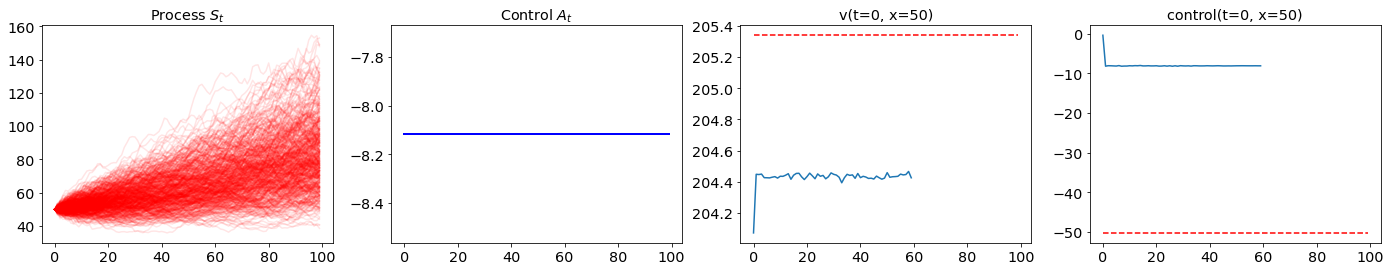

 60%|██████████████████████▊               | 6000/10000 [06:47<03:48, 17.47it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


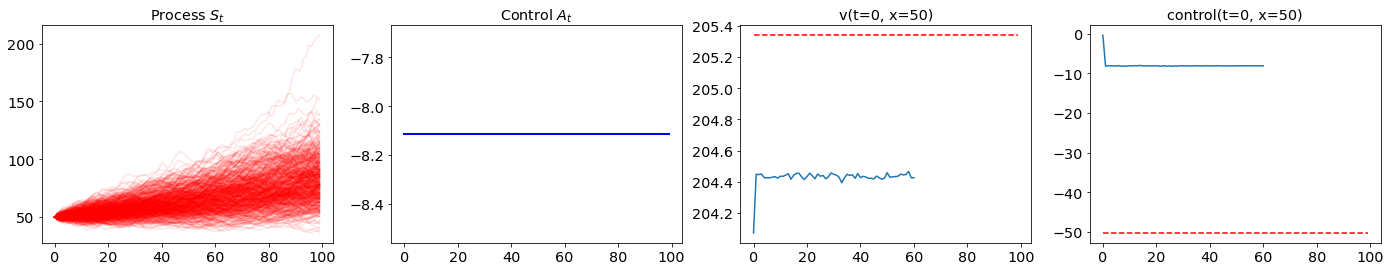

 61%|███████████████████████▏              | 6100/10000 [06:54<03:41, 17.58it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.41 
 theoretical constant optimal control: -50.25


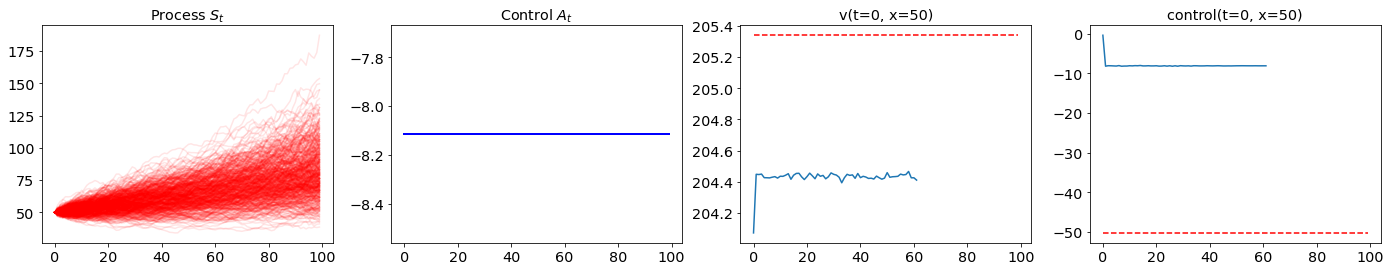

 62%|███████████████████████▌              | 6200/10000 [07:01<03:36, 17.56it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


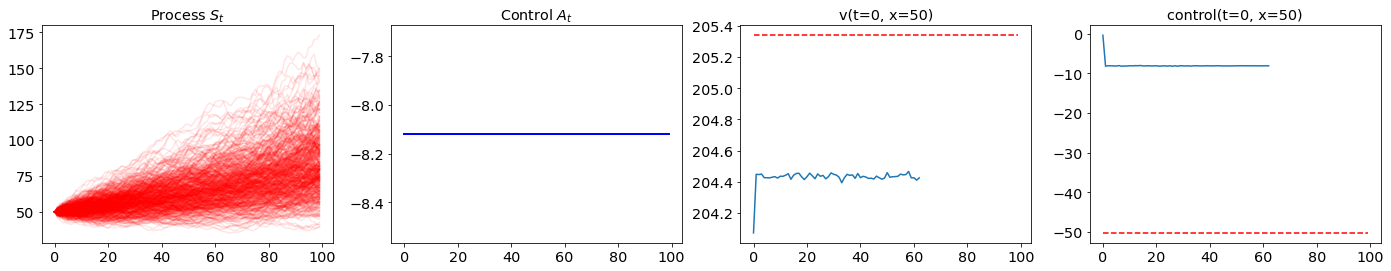

 63%|███████████████████████▉              | 6300/10000 [07:07<03:30, 17.56it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


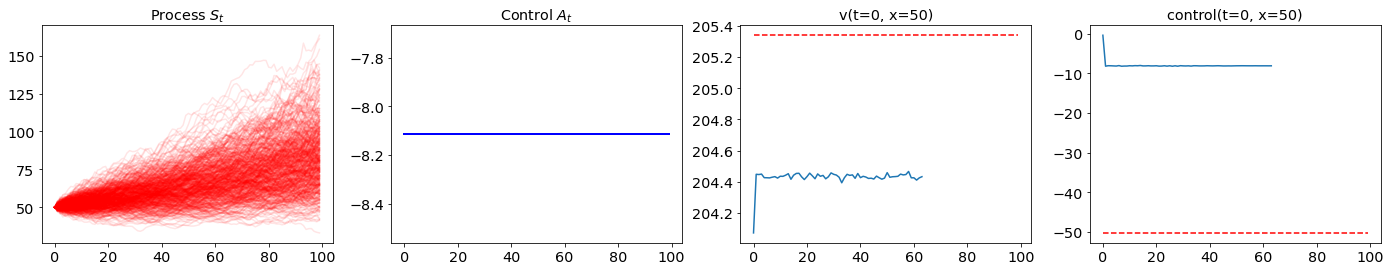

 64%|████████████████████████▎             | 6400/10000 [07:14<03:25, 17.48it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


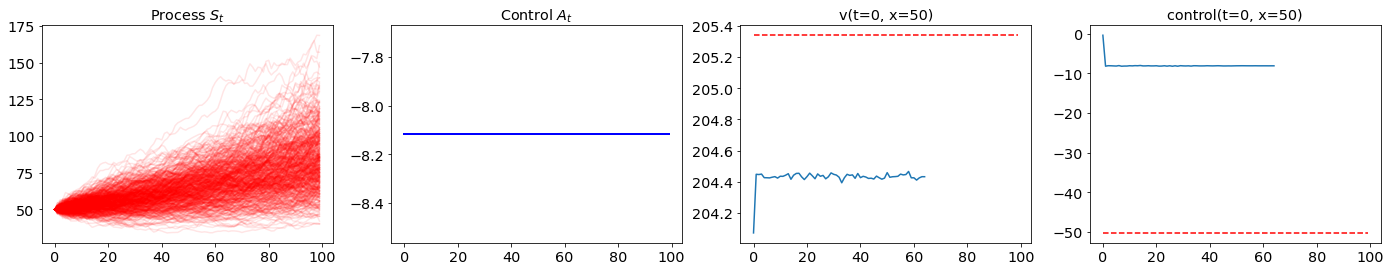

 65%|████████████████████████▋             | 6500/10000 [07:21<03:22, 17.32it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


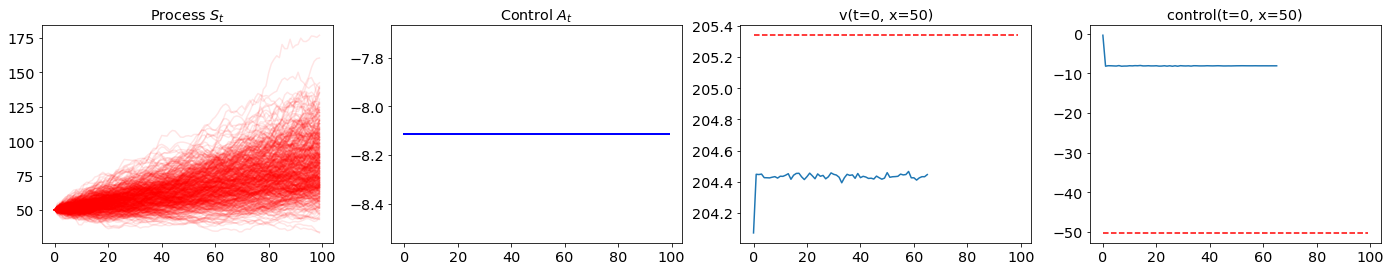

 66%|█████████████████████████             | 6600/10000 [07:27<03:11, 17.73it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


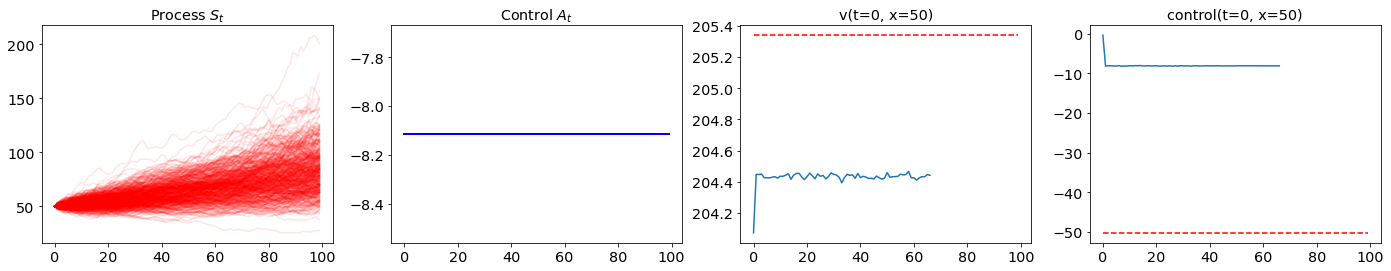

 67%|█████████████████████████▍            | 6700/10000 [07:34<03:10, 17.36it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


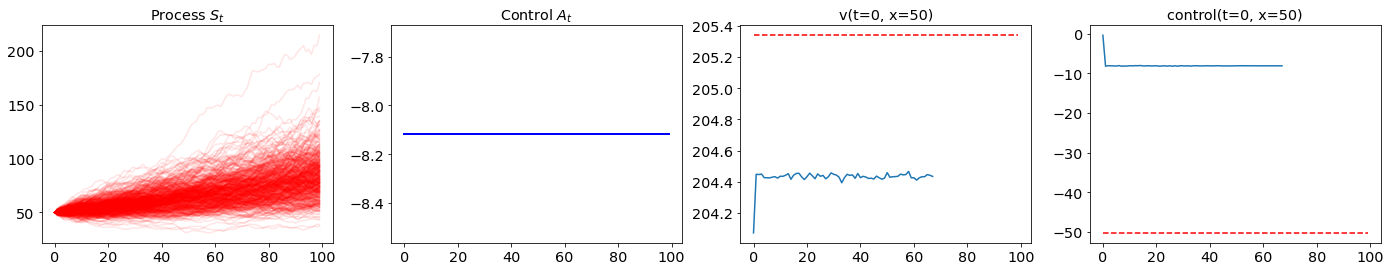

 68%|█████████████████████████▊            | 6800/10000 [07:41<03:01, 17.64it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


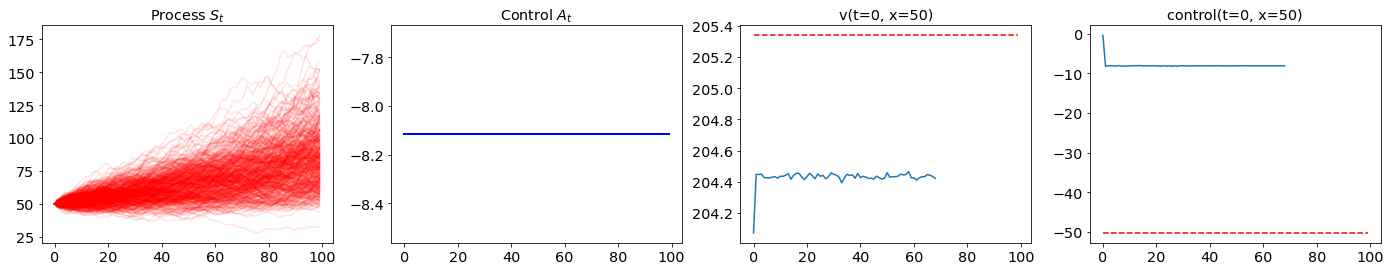

 69%|██████████████████████████▏           | 6900/10000 [07:48<02:59, 17.23it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


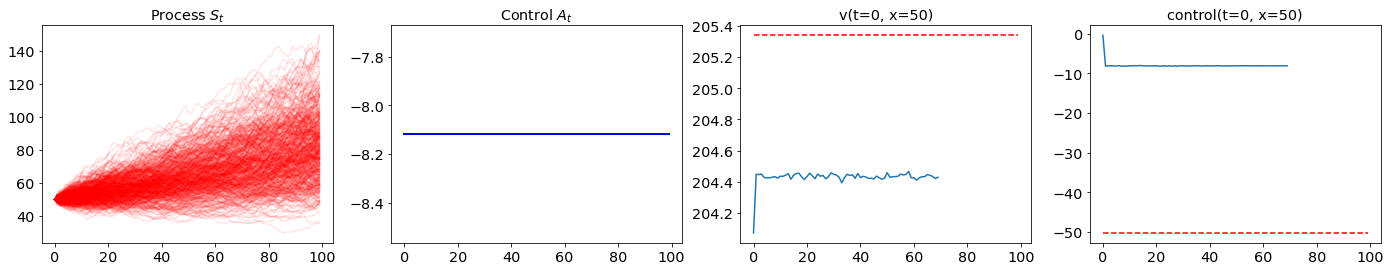

 70%|██████████████████████████▌           | 7000/10000 [07:54<02:50, 17.64it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


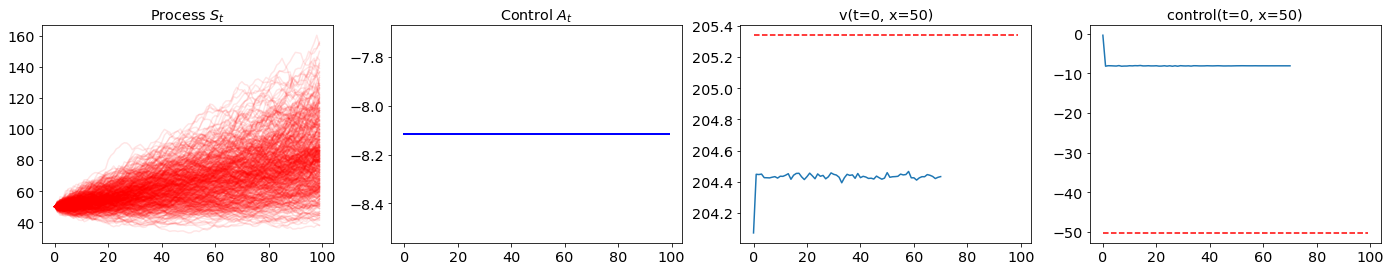

 71%|██████████████████████████▉           | 7100/10000 [08:01<02:43, 17.78it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


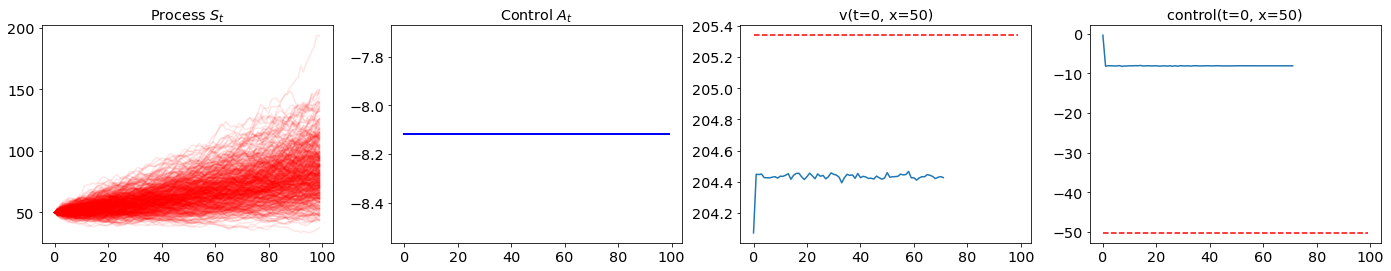

 72%|███████████████████████████▎          | 7200/10000 [08:08<02:37, 17.80it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


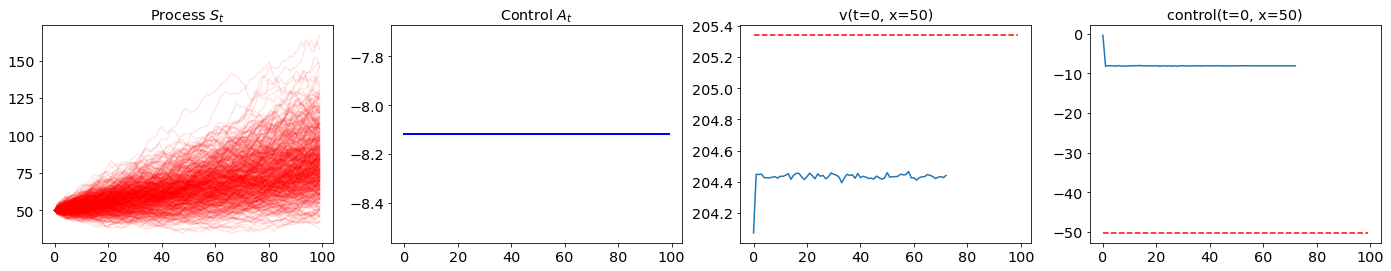

 73%|███████████████████████████▋          | 7300/10000 [08:15<02:35, 17.37it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


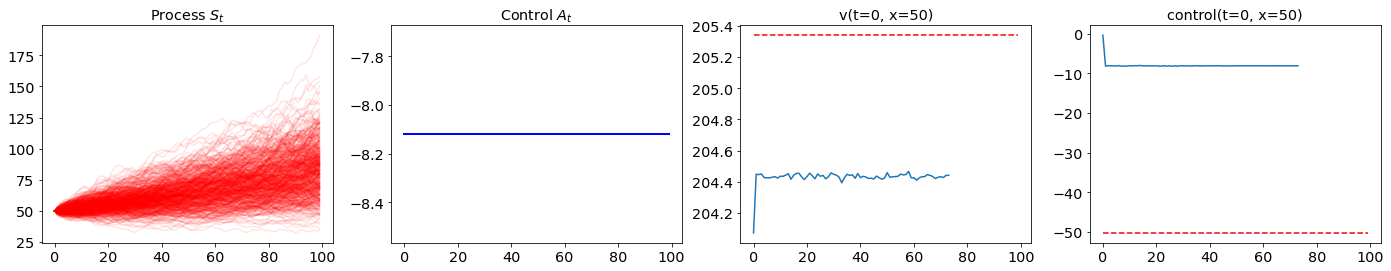

 74%|████████████████████████████          | 7400/10000 [08:21<02:28, 17.56it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


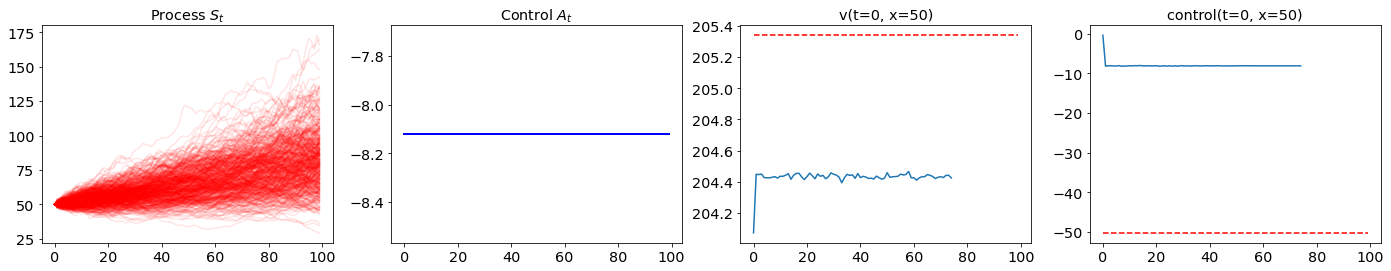

 75%|████████████████████████████▌         | 7500/10000 [08:28<02:23, 17.41it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


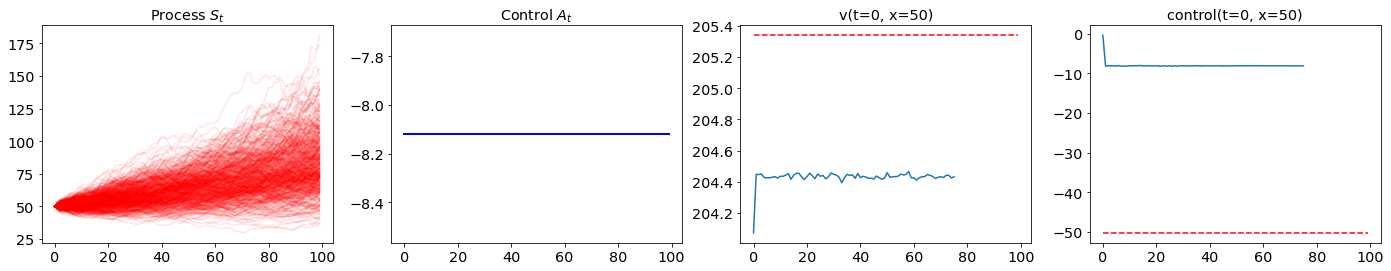

 76%|████████████████████████████▉         | 7600/10000 [08:35<02:19, 17.26it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.47 
 theoretical constant optimal control: -50.25


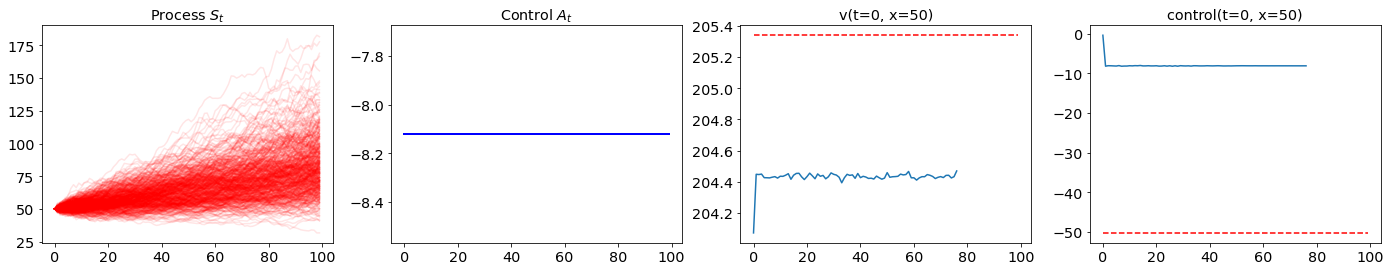

 77%|█████████████████████████████▎        | 7700/10000 [08:42<02:13, 17.23it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


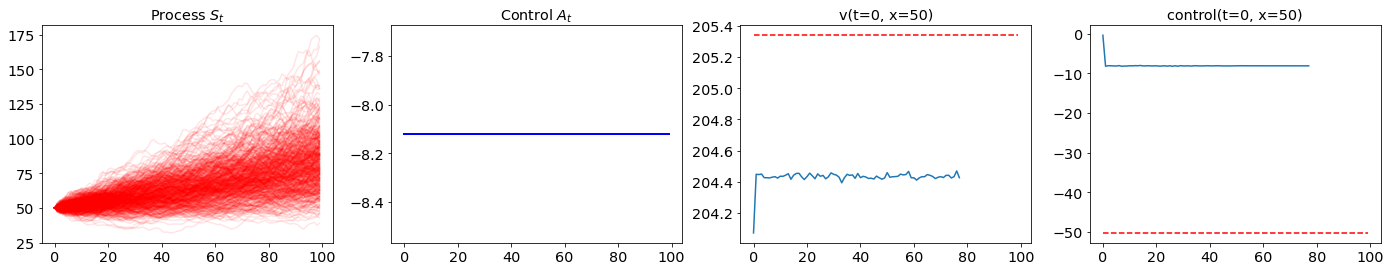

 78%|█████████████████████████████▋        | 7800/10000 [08:48<02:04, 17.64it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


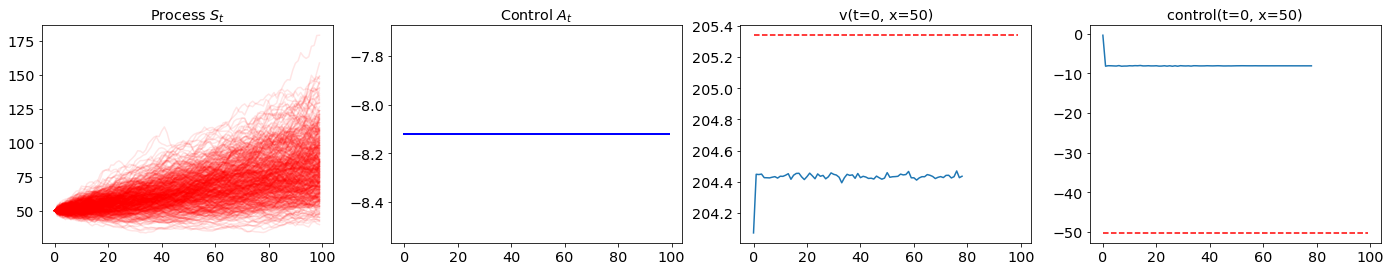

 79%|██████████████████████████████        | 7900/10000 [08:55<02:01, 17.34it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


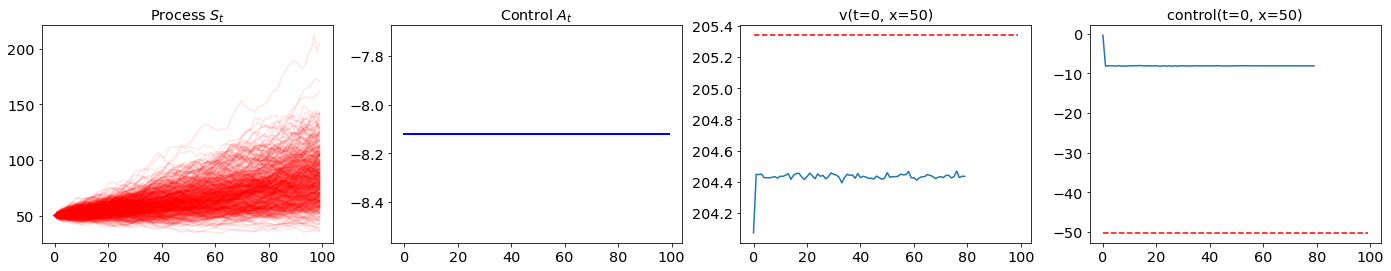

 80%|██████████████████████████████▍       | 8000/10000 [09:02<01:53, 17.63it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


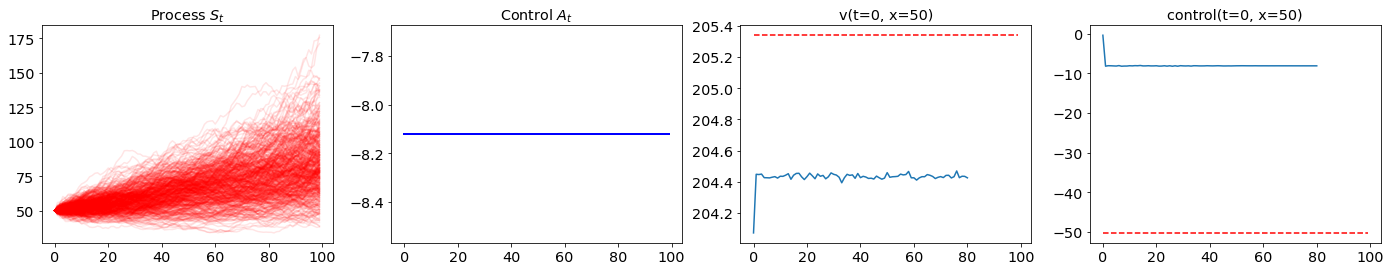

 81%|██████████████████████████████▊       | 8100/10000 [09:08<01:47, 17.68it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


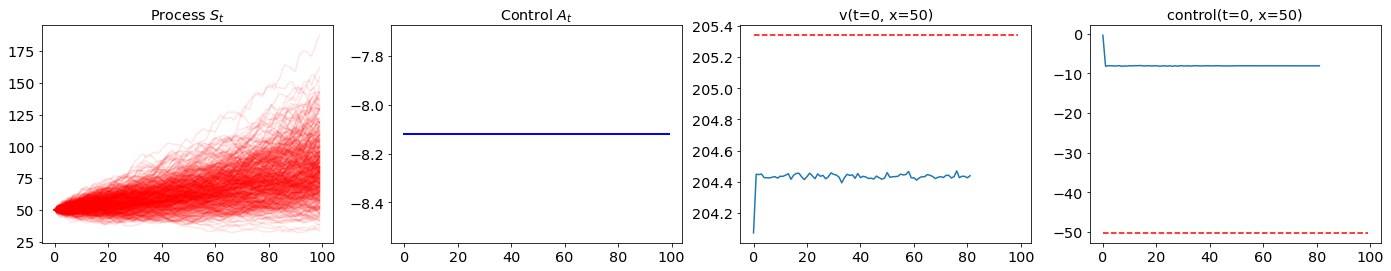

 82%|███████████████████████████████▏      | 8200/10000 [09:15<01:41, 17.75it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


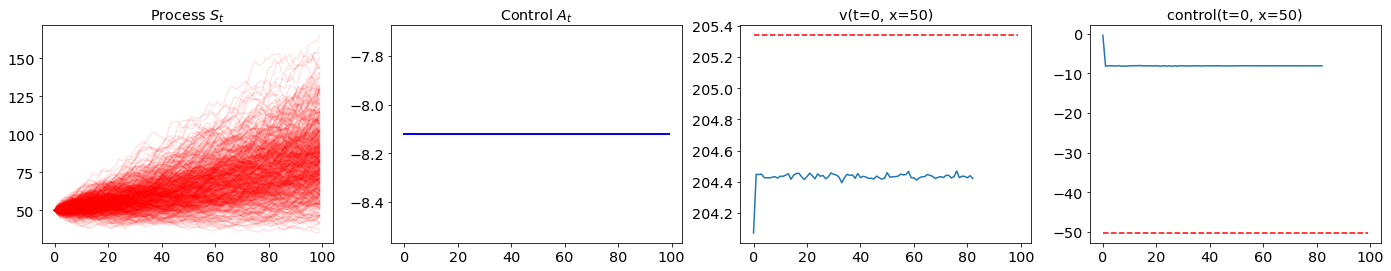

 83%|███████████████████████████████▌      | 8300/10000 [09:22<01:36, 17.68it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


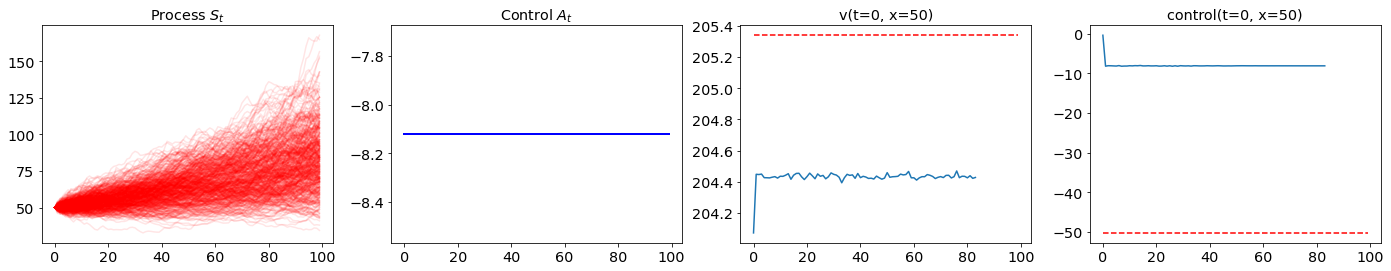

 84%|███████████████████████████████▉      | 8400/10000 [09:29<01:33, 17.17it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


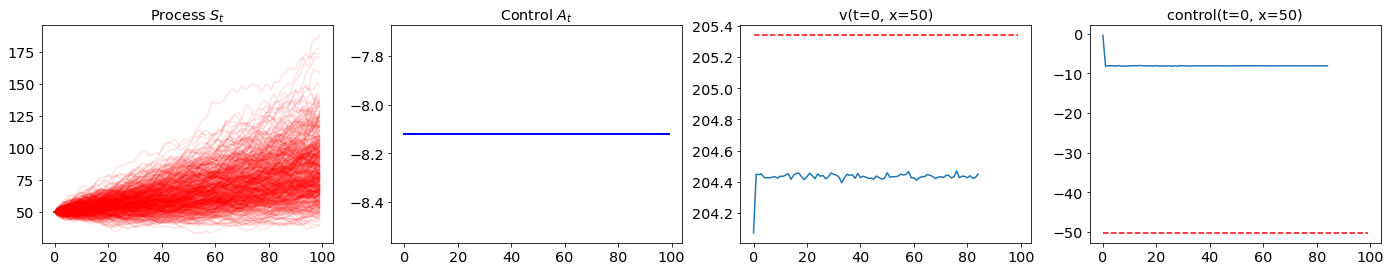

 85%|████████████████████████████████▎     | 8500/10000 [09:35<01:24, 17.67it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


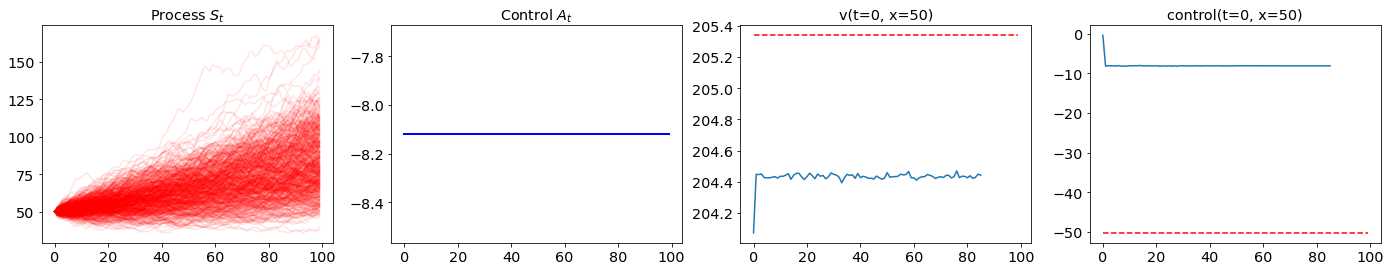

 86%|████████████████████████████████▋     | 8600/10000 [09:42<01:19, 17.51it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


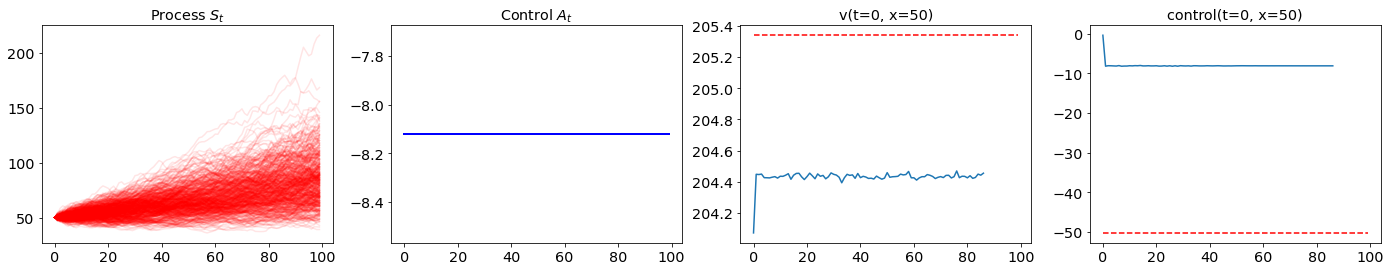

 87%|█████████████████████████████████     | 8700/10000 [09:49<01:14, 17.45it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


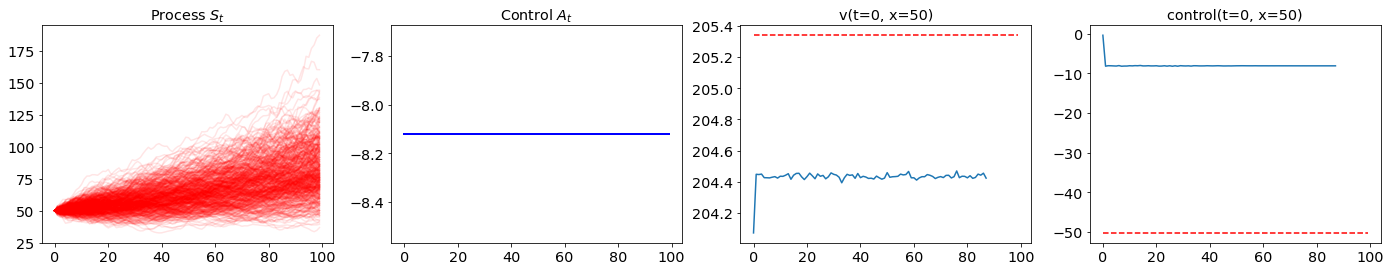

 88%|█████████████████████████████████▍    | 8800/10000 [09:56<01:07, 17.79it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


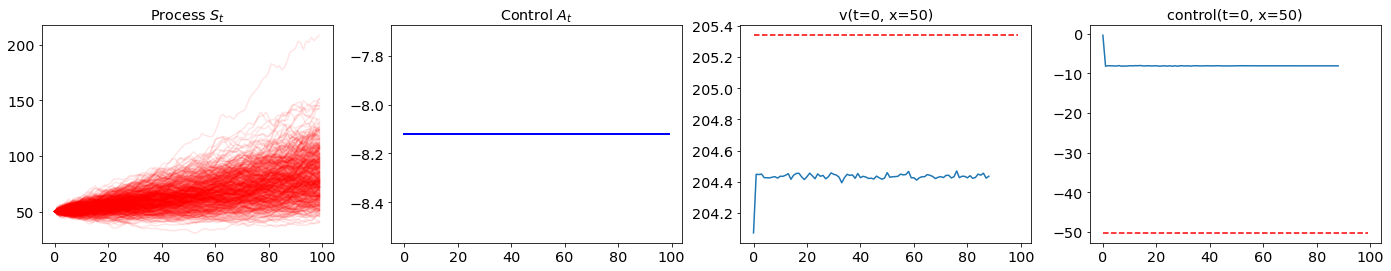

 89%|█████████████████████████████████▊    | 8900/10000 [10:02<01:01, 17.77it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.41 
 theoretical constant optimal control: -50.25


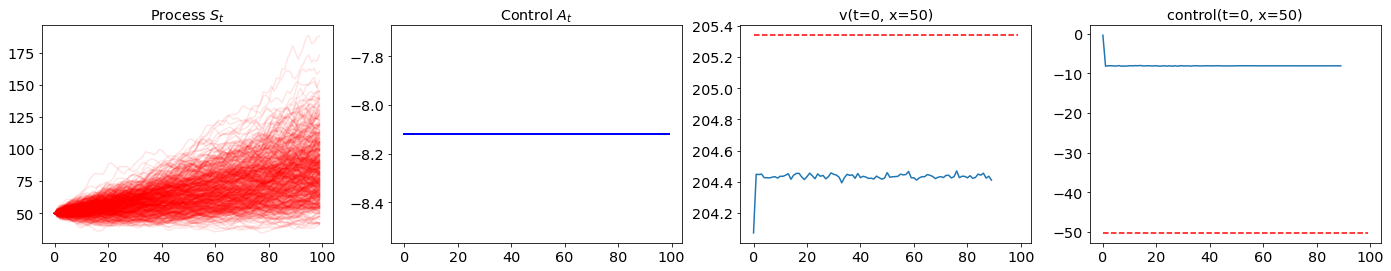

 90%|██████████████████████████████████▏   | 9000/10000 [10:09<00:56, 17.71it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


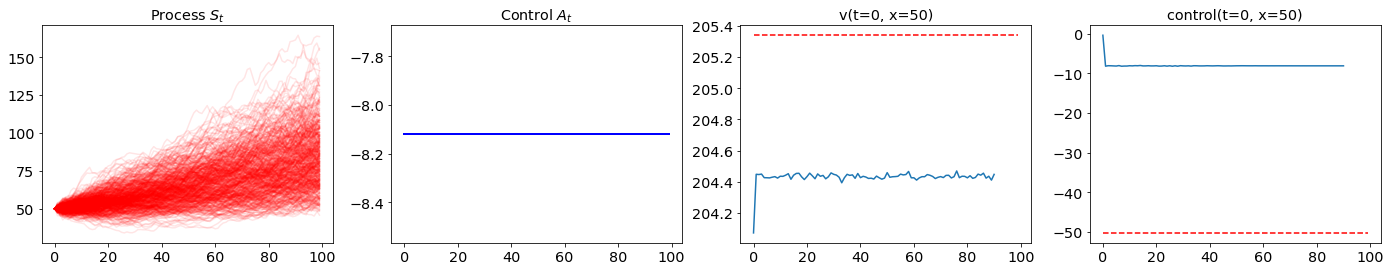

 91%|██████████████████████████████████▌   | 9100/10000 [10:16<00:51, 17.31it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


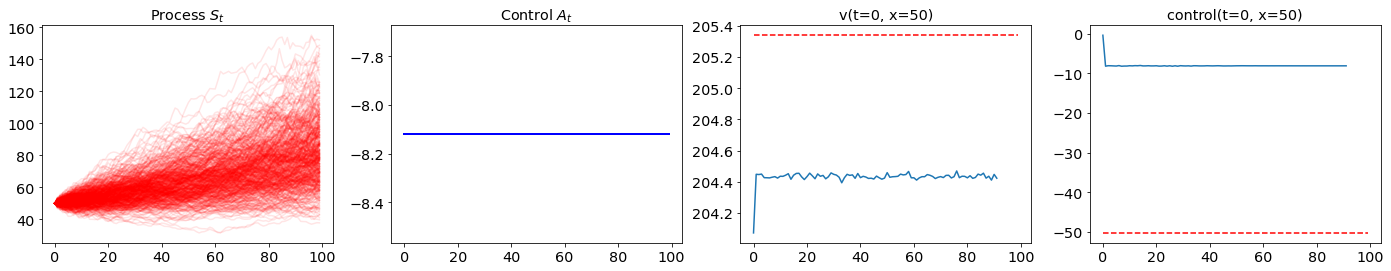

 92%|██████████████████████████████████▉   | 9200/10000 [10:22<00:45, 17.48it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


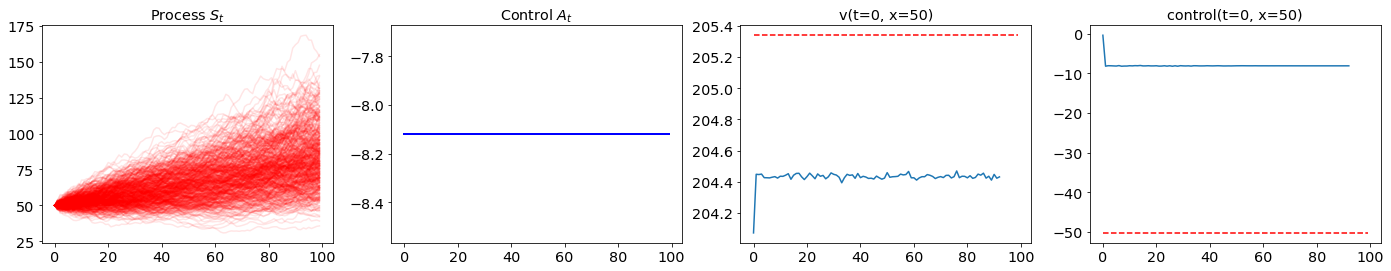

 93%|███████████████████████████████████▎  | 9300/10000 [10:29<00:39, 17.56it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


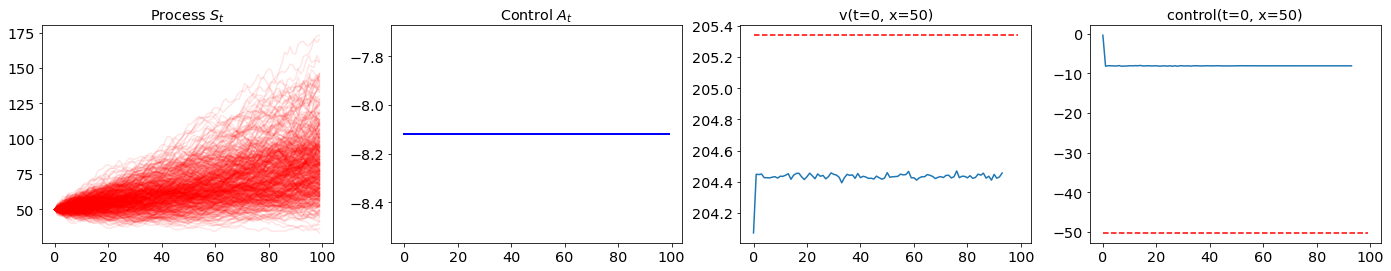

 94%|███████████████████████████████████▋  | 9400/10000 [10:36<00:33, 17.81it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.44 
 theoretical constant optimal control: -50.25


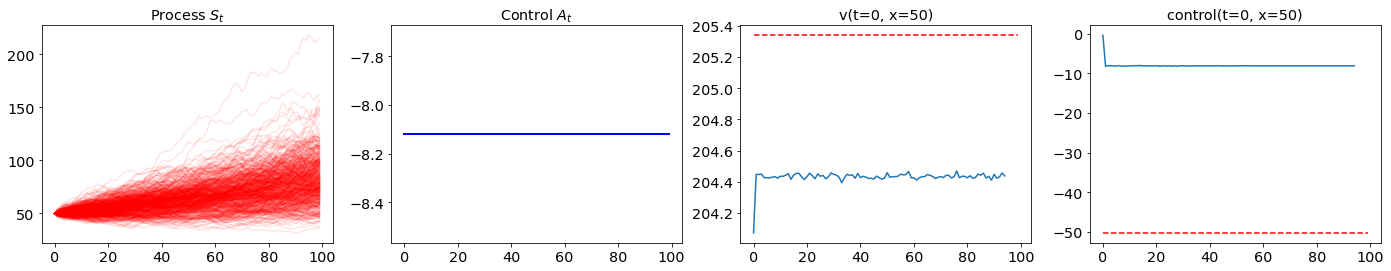

 95%|████████████████████████████████████  | 9500/10000 [10:43<00:28, 17.60it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


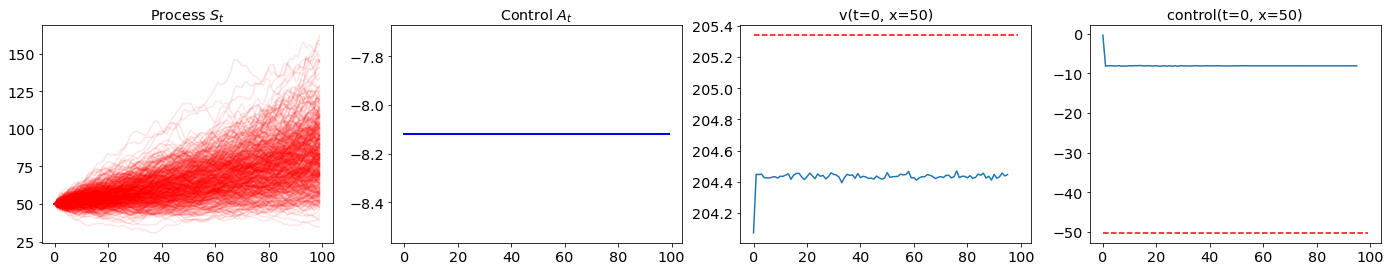

 96%|████████████████████████████████████▍ | 9600/10000 [10:49<00:23, 17.17it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.45 
 theoretical constant optimal control: -50.25


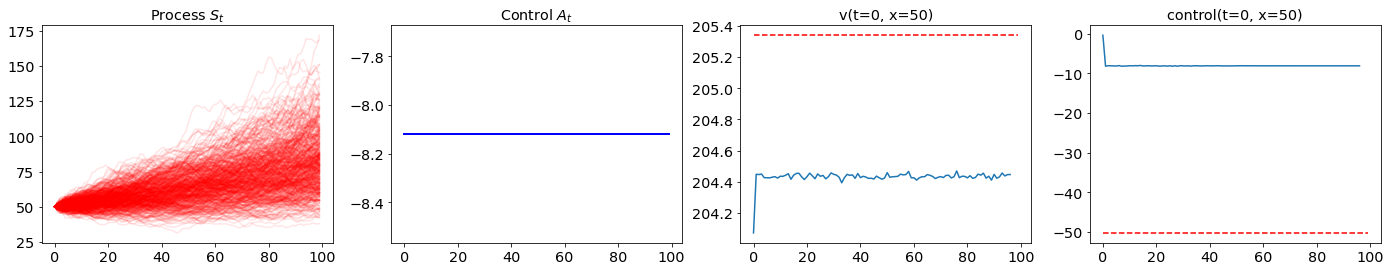

 97%|████████████████████████████████████▊ | 9700/10000 [10:56<00:17, 17.48it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


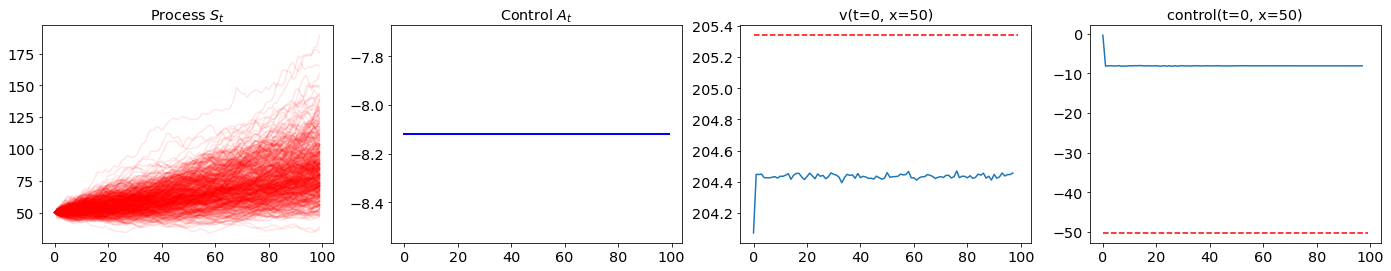

 98%|█████████████████████████████████████▏| 9800/10000 [11:03<00:11, 17.50it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.43 
 theoretical constant optimal control: -50.25


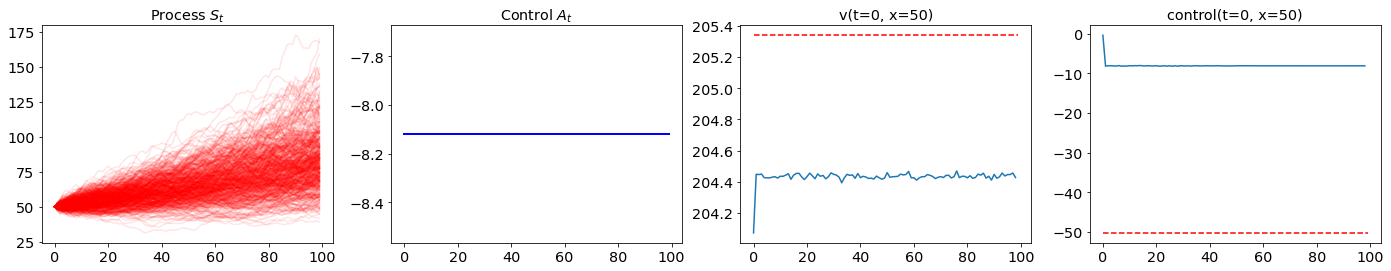

 99%|█████████████████████████████████████▌| 9900/10000 [11:10<00:05, 17.51it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.42 
 theoretical constant optimal control: -50.25


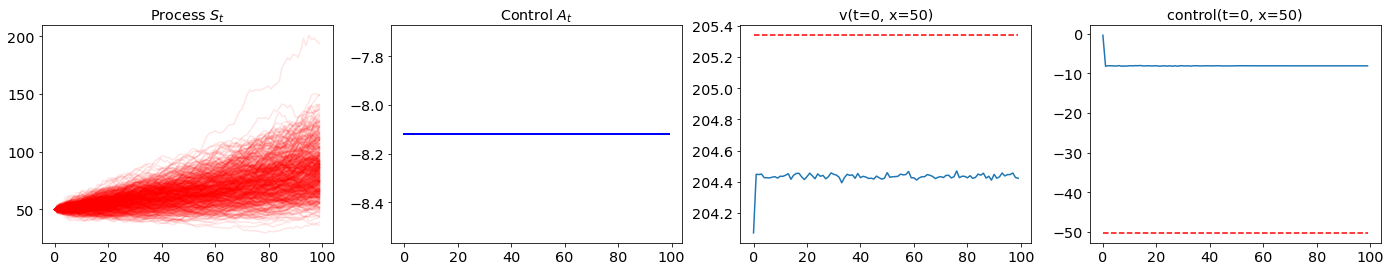

100%|█████████████████████████████████████▉| 9998/10000 [11:16<00:00, 17.60it/s]

 
 initial condition: 50 
 theoretical value function: 205.34 
 predicted value function: 204.46 
 theoretical constant optimal control: -50.25


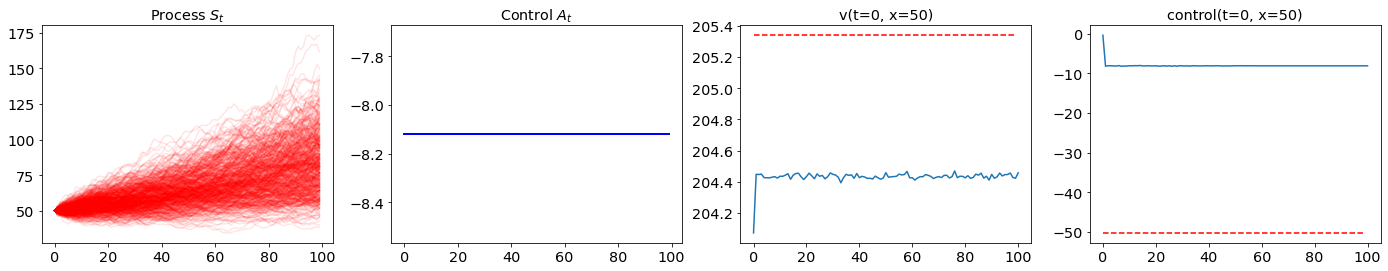

100%|█████████████████████████████████████| 10000/10000 [11:17<00:00, 14.75it/s]


In [12]:
# training loop
trange = tqdm.tqdm(range(iterations))

for step in trange:

    # random initial condition
    # s0 = np.random.uniform(low=1.0, high=2.0)
    s0 = 50
    x0_batch = np.log(s0)*torch.ones(batch_size, 1, device=device)

    optimiser.zero_grad()
    
    generated_samples = model(x0_batch, ts)

    x = generated_samples[...,0]
    
    s_T = torch.exp(x[:,-1])
    
    loss = -torch.mean(s_T**p/p)

    loss.backward()

    optimiser.step()
    
    scheduler.step()

    if (step % iterations_per_print) == 0 or step == iterations - 1:
        with torch.no_grad():

            # random initial condition
            # s0 = np.random.uniform(low=1.0, high=2.0)

            # theoretical optimal control and value function v(t=0,s=s_0)
            a = (mu-r)/((sigma**2)*(1.-p))
            rho = p*((mu-r)**2)/(2.*(sigma**2)*(1.-p)) + r*p
            v = np.exp(rho*T)*(s0**p/p)

            x0_batch = np.log(s0)*torch.ones(batch_size, 1, device=device)

            generated_samples = model(x0_batch, ts)

            x = generated_samples
            s_T = torch.exp(x[:,-1])
            alpha = torch.mean(torch.tensor(model._func.f_theta(x).cpu().numpy()))
            
            loss = torch.mean(s_T**p/p)
#             print(alpha)
#             print(loss)
            v_theo = np.round(v,2)
            a_theo = np.round(a,2)

            v_list = []
            a_list = []
            for i in range(times):
                v_list.append(v_theo)
                a_list.append(a_theo)
            
            print(f' \n initial condition: {np.round(s0,2)} \n',
                  f'theoretical value function: {v_theo} \n', 
                  f'predicted value function: {np.round(loss.cpu().numpy().item(),2)} \n',
                  f'theoretical constant optimal control: {a_theo}'
                  )

            losses.append(loss)
            controls.append(alpha)

            results_plot(model, x0_batch, losses, controls, T, batch_size, t_size_test, v_list, a_list, times, t_size_test)

In [13]:
controls

[tensor(-0.4076),
 tensor(-8.2096),
 tensor(-8.0901),
 tensor(-8.1076),
 tensor(-8.1406),
 tensor(-8.1736),
 tensor(-8.0597),
 tensor(-8.2178),
 tensor(-8.1755),
 tensor(-8.1738),
 tensor(-8.0958),
 tensor(-8.1326),
 tensor(-8.0731),
 tensor(-8.0990),
 tensor(-8.0359),
 tensor(-8.1380),
 tensor(-8.1345),
 tensor(-8.0950),
 tensor(-8.1416),
 tensor(-8.1357),
 tensor(-8.1030),
 tensor(-8.1929),
 tensor(-8.1773),
 tensor(-8.1017),
 tensor(-8.1975),
 tensor(-8.1044),
 tensor(-8.2214),
 tensor(-8.1058),
 tensor(-8.2173),
 tensor(-8.0848),
 tensor(-8.1314),
 tensor(-8.1508),
 tensor(-8.1203),
 tensor(-8.1873),
 tensor(-8.0944),
 tensor(-8.1036),
 tensor(-8.1381),
 tensor(-8.1414),
 tensor(-8.1301),
 tensor(-8.0966),
 tensor(-8.1197),
 tensor(-8.1362),
 tensor(-8.1171),
 tensor(-8.0943),
 tensor(-8.1152),
 tensor(-8.1500),
 tensor(-8.1461),
 tensor(-8.1342),
 tensor(-8.1447),
 tensor(-8.1248),
 tensor(-8.1090),
 tensor(-8.1051),
 tensor(-8.0964),
 tensor(-8.1015),
 tensor(-8.1103),
 tensor(-8

In [14]:
dadsda.a

NameError: name 'dadsda' is not defined

In [ ]:
import pandas as pd
# change data type to float
controls_ = list(map(float,controls))
losses_ = list(map(float,losses))

In [ ]:
# # 导入CSV模块
# import csv
# # first time write data in csv.
 
# # 1. 创建文件对象（指定文件名，模式，编码方式）
# # with open("p2_controls.csv", "w", encoding="gbk", newline="") as f:
# with open("p2_controls.csv", "w") as f:
#     # 2. 基于文件对象构建 csv写入对象
#     csv_writer = csv.writer(f)
# #     # 3. 构建列表头
#     csv_writer.writerow(range(1,42))
#     # 4. 写入csv文件内容
#     csv_writer.writerow(controls_)
#     print("data save successful")
#     # 5. 关闭文件
#     f.close()
    
# # 1. 创建文件对象（指定文件名，模式，编码方式）
# # with open("p2_losses.csv", "w", encoding="gbk", newline="") as f:
# with open("p2_losses.csv", "w") as f:
#     # 2. 基于文件对象构建 csv写入对象
#     csv_writer = csv.writer(f)
#     # 3. 构建列表头
#     csv_writer.writerow(range(1,42))
#     # 4. 写入csv文件内容
#     csv_writer.writerow(losses_)
#     print("data save successful")
#     # 5. 关闭文件
#     f.close()




In [ ]:
# 导入CSV模块
import csv
# write new data
 
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("p1_controls.csv", "a", encoding="gbk", newline="") as f:
with open("p2_controls.csv", "a") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
#     csv_writer.writerow(range(1,42))
    # 4. 写入csv文件内容
    csv_writer.writerow(controls_)
    print("data save successful")
    # 5. 关闭文件
    f.close()
    
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("p1_losses.csv", "a", encoding="gbk", newline="") as f:
with open("p2_losses.csv", "a") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
#     csv_writer.writerow(range(1,42))
    # 4. 写入csv文件内容
    csv_writer.writerow(losses_)
    print("data save successful")
    # 5. 关闭文件
    f.close()





In [ ]:
reader_controls = pd.read_csv("p2_controls.csv")
reader_losses = pd.read_csv("p2_losses.csv")
reader_controls

In [ ]:
reader_losses